In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
# Apply the default theme
sns.set_theme()

import os
from pathlib import Path
import itertools

from data import name_to_dataset

RESULTS_PATH = 'results/'
AGREE_PATH = os.path.join(RESULTS_PATH, 'agree')
ERRORS_PATH = os.path.join(RESULTS_PATH, 'errors')

MODELS = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree',
    'RandomForest2',
    'RandomForest4',
    'RandomForest8',
    'RandomForest16',
    'RandomForest',
    'XGBoost',
    'MLP'
    ]
# LogisticRegressionSGD

DATASETS = [
    'adult',
    'communities',
    'compas',
    'german',
    'incomeCA',
    'incomeNY',
    'incomeTX',
    'employmentCA',
    'employmentNY',
    'employmentTX',
    'coverageCA',
    'coverageNY',
    'coverageTX'
    ]

In [2]:
# Some setup for Folktables datasets
GROUPS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
FOLK_RACE_GROUPS = [1, 2, 3, 4, 5, 6, 7]
FOLK_SEX_GROUPS = [8, 9]
FOLK_AGE_GROUPS = [10, 11]

RACE_SEX_INTERSECTIONS = list(itertools.product(FOLK_RACE_GROUPS, FOLK_SEX_GROUPS))
RACE_SEX_INTERSECTIONS = [str(pair).replace(" ", "") for pair in RACE_SEX_INTERSECTIONS]

RACE_AGE_INTERSECTIONS = list(itertools.product(FOLK_RACE_GROUPS, FOLK_AGE_GROUPS))
RACE_AGE_INTERSECTIONS = [str(pair).replace(" ", "") for pair in RACE_AGE_INTERSECTIONS]

AGE_SEX_INTERSECTIONS = list(itertools.product(FOLK_AGE_GROUPS, FOLK_SEX_GROUPS))
AGE_SEX_INTERSECTIONS = [str(pair).replace(" ", "") for pair in AGE_SEX_INTERSECTIONS]

ALL_INTERSECTIONS = list(itertools.product(['ALL'], GROUPS))
ALL_INTERSECTIONS = [str(pair).replace(" ", "") for pair in ALL_INTERSECTIONS]
ALL_INTERSECTIONS = [str(pair).replace("'", "") for pair in ALL_INTERSECTIONS]

# Agreement Data

In [3]:
def load_agree_results(dataset, model):
    dataset_obj = name_to_dataset(dataset)
    path = os.path.join(os.path.join(AGREE_PATH, dataset), 
                        "{}.pt".format(model))
    
    return_dict = {}
    groups = dataset_obj.group_names
    return_dict['name'] = dataset
    return_dict['groups'] = groups
    return_dict['intersections'] = dataset_obj.intersections
    raw_results = torch.load(path)

    # Convert format of results
    results = {}
    errs = {}
    result_names = []
    for (g1, g2) in dataset_obj.intersections:
        key = "({},{})".format(groups[g1], groups[g2])
        new_key = "({},{})".format(g1, g2)
        result_names.append(key)
        results[new_key] = raw_results[key][0]
        errs[new_key] = raw_results[key][1]
    for i, g in enumerate(groups[1:]):
        key = "(ALL, {})".format(g)
        new_key = "(ALL,{})".format(i + 1)
        result_names.append(key)
        results[new_key] = raw_results[key][0]
        errs[new_key] = raw_results[key][1]

    return_dict['result_names'] = result_names
    return_dict['results'] = results
    return_dict['std_errs'] = errs
    return return_dict

In [4]:
def model_agree_df(model, datasets, intersections):
    """
    Creates a dataframe for each fixed model with the agreement data for each dataset. Columns are the intersections, rows are the datasets.
    """
    rows = datasets
    cols = intersections
    df = pd.DataFrame(index=rows, columns=cols)
    df_errs = pd.DataFrame(columns=cols)

    for dataset in datasets:
        results = load_agree_results(dataset, model)
        name = results['name']
        df.loc[name] = results['results']
        df_errs.loc["{}_err".format(name)] = results['std_errs']

    df = pd.concat([df, df_errs])
    return df

def dataset_agree_df(models, dataset, intersections):
    """
    Creates a dataframe for each fixed dataset with the agreement data for each model. Columns are the intersections, rows are the models.
    """
    rows = models
    cols = intersections
    df = pd.DataFrame(index=rows, columns=cols)
    df_errs = pd.DataFrame(columns=cols)

    for model in models:
        results = load_agree_results(dataset, model)
        df.loc[model] = results['results']
        df_errs.loc["{}_err".format(model)] = results['std_errs']

    df = pd.concat([df, df_errs])
    return df

In [5]:
# Dataframe 1: Fixed model, rows=datasets, cols=intersections
small_datasets = DATASETS[:4]
small_dataset_intersections = ["(1,3)", "(1,4)", "(2,3)", "(2,4)", 
                         "(ALL,1)", "(ALL,2)", "(ALL,3)", "(ALL,4)"]
big_datasets = DATASETS[4:]
big_dataset = load_agree_results(big_datasets[0], MODELS[0])
big_intersections = big_dataset['intersections']
big_groups = big_dataset['groups']
big_dataset_intersections = [str(inter).replace(" ", "") for inter in big_intersections]
for g in range(1, len(big_groups)):
    big_dataset_intersections.append("(ALL,{})".format(g))

# Create a DF for each model
DF_PATH = os.path.join(AGREE_PATH, 'dfs')
fixed_model_dir = os.path.join(DF_PATH, 'fixed_model')
Path(fixed_model_dir).mkdir(parents=True, exist_ok=True)
small_model_dfs_agree = {}
big_model_dfs_agree = {}
for model in MODELS:
    small_path = os.path.join(fixed_model_dir, "{}_small.csv".format(model))
    try:
        small_model_dfs_agree[model] = pd.read_csv(small_path, index_col=0)
    except FileNotFoundError:
        small_model_dfs_agree[model] = model_agree_df(model, small_datasets,
                                                small_dataset_intersections)
        small_model_dfs_agree[model].to_csv(small_path)
    big_path = os.path.join(fixed_model_dir, "{}_big.csv".format(model))
    try:
        big_model_dfs_agree[model] = pd.read_csv(big_path, index_col=0)
    except FileNotFoundError:
        big_model_dfs_agree[model] = model_agree_df(model, big_datasets,
                                            big_dataset_intersections)
        big_model_dfs_agree[model].to_csv(big_path)
        
# Create a DF for each dataset
fixed_dataset_dir = os.path.join(DF_PATH, 'fixed_dataset')
Path(fixed_dataset_dir).mkdir(parents=True, exist_ok=True)
dataset_dfs_agree = {}
for dataset in DATASETS:
    path = os.path.join(fixed_dataset_dir, "{}.csv".format(dataset))
    try:
        dataset_dfs_agree[dataset] = pd.read_csv(path, index_col=0)
    except FileNotFoundError:
        if dataset in small_datasets:
            dataset_dfs_agree[dataset] = dataset_agree_df(MODELS, dataset,
                                                small_dataset_intersections)
        else:
            dataset_dfs_agree[dataset] = dataset_agree_df(MODELS, dataset,
                                                    big_dataset_intersections)
        dataset_dfs_agree[dataset].to_csv(path)

## Plot: Agreements for fixed model class

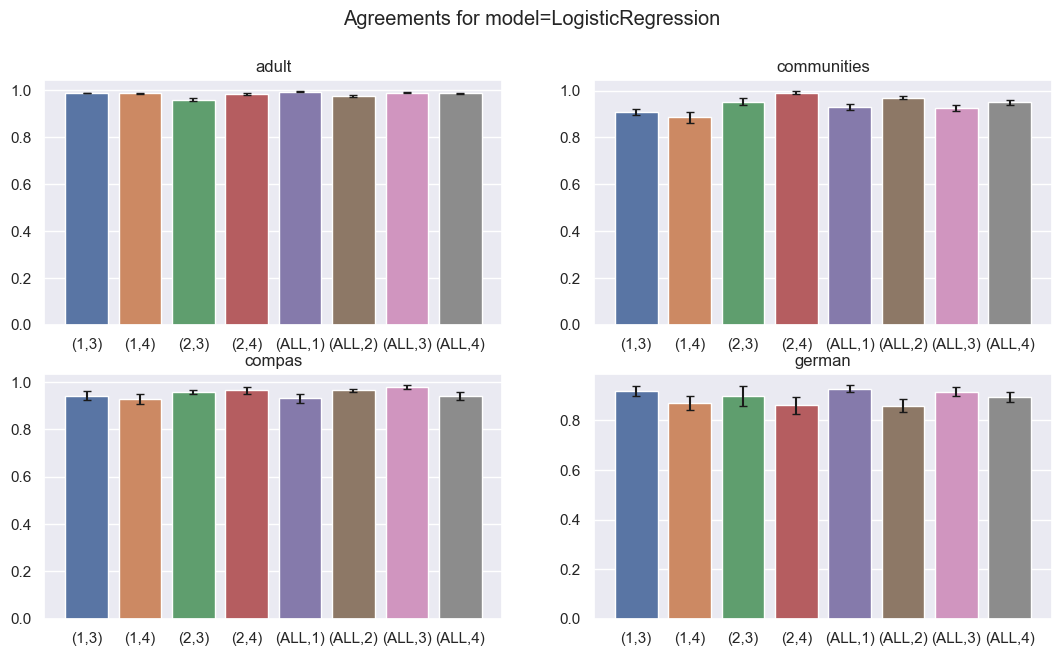

In [6]:
# Plot for each model
# Small datasets
model = MODELS[0]
fig, axs = plt.subplots(2, 2, figsize=(13, 7))
fig.suptitle("Agreements for model={}".format(model))
indices = itertools.product([0, 1], [0, 1])

for dataset, (i,j) in zip(small_datasets, indices):
    data = small_model_dfs_agree[model].loc[dataset]
    errs = small_model_dfs_agree[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i][j], x=data.index, y=data.values)
    axs[i][j].set_title(dataset)
    axs[i][j].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
plt.show()

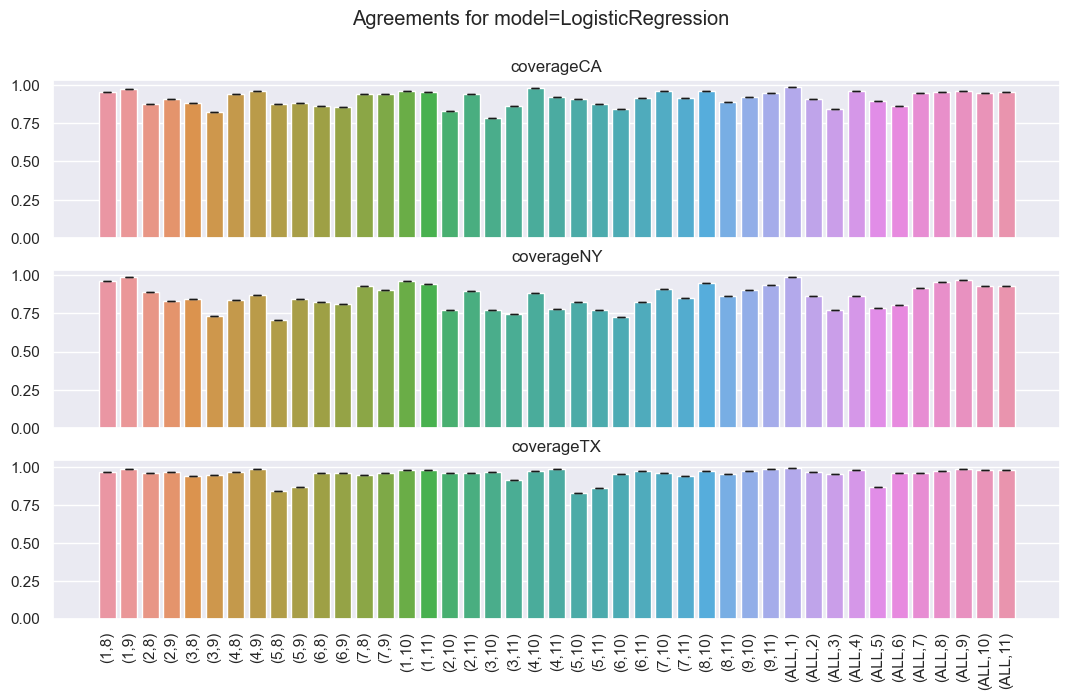

In [7]:
# Large datasets
fig, axs = plt.subplots(3, 1, figsize=(13, 7))
fig.suptitle("Agreements for model={}".format(model))
income_datasets = big_datasets[:3]
employment_datasets = big_datasets[3:6]
coverage_datasets = big_datasets[6:9]

# Income Datasets
plt.xticks(rotation=90)
for i, dataset in enumerate(coverage_datasets):
    data = big_model_dfs_agree[model].loc[dataset]
    errs = big_model_dfs_agree[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i], x=data.index, y=data.values)
    axs[i].set_title(dataset)
    axs[i].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
    if i < 2:
        axs[i].set(xticklabels=[])
plt.show()

## Plot: Agreements for fixed dataset

In [128]:
def plot_agreement(ax, name, data, models, intersections):
    # Preprocess the data into a vertical DF
    rows = []
    for (intersection, model) in itertools.product(intersections, models):
        row = {}
        row['intersection'] = intersection
        row['model'] = model
        row['agreement'] = data.loc[intersection][model]
        err = data.loc[intersection]["{}_err".format(model)]
        lerr = err
        uerr = min([1.0 - data.loc[intersection][model], err])
        row['lerr'] = lerr
        row['uerr'] = uerr
        rows.append(row)

    df = pd.DataFrame(rows)
    df['model'] = pd.Categorical(df['model'], models)
    df['intersection'] = pd.Categorical(df['intersection'], intersections)

    # Plot the data
    err = []
    lerr = df.pivot(index='intersection', columns='model', values='lerr')
    uerr = df.pivot(index='intersection', columns='model', values='uerr')
    for col in lerr:
        err.append([lerr[col].values, uerr[col].values])
    p = df.pivot(index='intersection', columns='model', values='agreement')
    if 'DecisionTree' in models:
        p = p.rename(columns={'DecisionTree': 'DecisionTree (any depth)'})
    ax = p.plot(kind='bar', yerr=err, ax=plt.gca())
    ax.set_ylabel('agreement')
    ax.set_title("Agreement for {}".format(name))
    ax.legend(loc='center', frameon=False, bbox_to_anchor=(0, 0.5, 2.25, 0))
    return ax

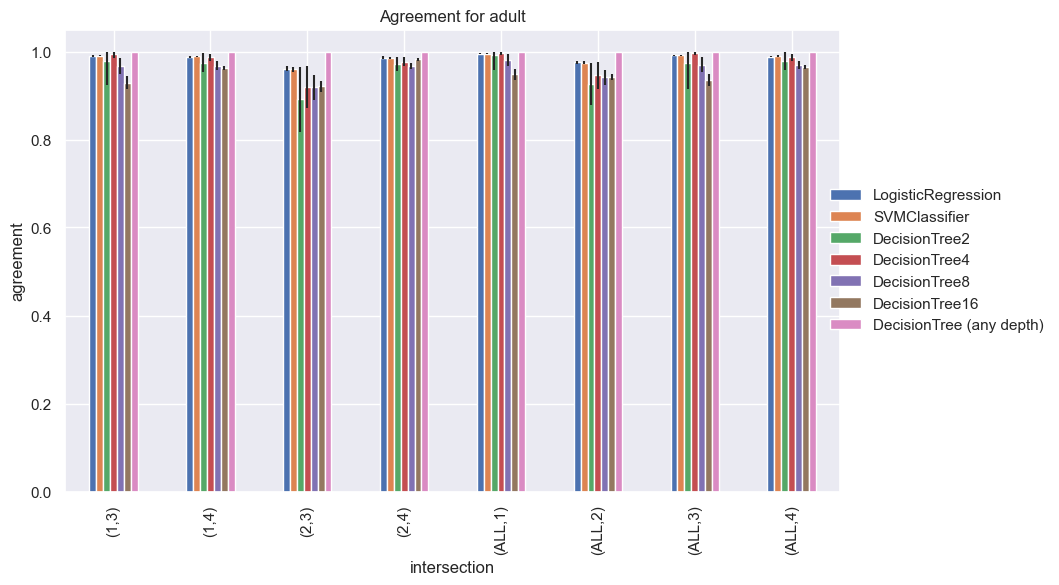

In [129]:
data = dataset_dfs_agree['adult'].transpose()
models = MODELS[:7]
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))

ax = plot_agreement(ax, 'adult', data, models, intersections)
plt.show()

# Error Data

In [10]:
def load_error_results(dataset, model):
    dataset_obj = name_to_dataset(dataset)
    path = os.path.join(os.path.join(ERRORS_PATH, dataset), 
                        "{}.pt".format(model))
    
    return_dict = {}
    groups = dataset_obj.group_names
    return_dict['name'] = dataset
    return_dict['groups'] = groups
    raw_results = torch.load(path)

    # Convert format of results
    return_dict['results'] = {}
    for g, group_name in enumerate(dataset_obj.group_names):
        erm_all_results = raw_results[g]['ERM_ALL']
        erm_all_err = erm_all_results[0] - erm_all_results[1][0]
        erm_group_results = raw_results[g]['ERM_GROUP']
        erm_group_err = erm_group_results[0] - erm_group_results[1][0]
        erm_prepend_results = raw_results[g]['PREPEND']
        erm_prepend_err = erm_prepend_results[0] - erm_prepend_results[1][0]

        return_dict['results'][g] = {}
        return_dict['results'][g]['ERM_ALL'] = (erm_all_results[0], erm_all_err)
        return_dict['results'][g]['ERM_GROUP'] = (erm_group_results[0], erm_group_err)
        return_dict['results'][g]['PREPEND'] = (erm_prepend_results[0], erm_prepend_err)
    return return_dict

In [11]:
def model_error_df(model, datasets, groups):
    """
    Creates a dataframe for each fixed model with the error data for each dataset. Columns are the groups and training method, rows are datasets.
    """
    rows = datasets

    # Construct columns
    cols = []
    for g in groups:
        cols.append("{} (ERM)".format(g))
        cols.append("{} (G-ERM)".format(g))
        cols.append("{} (PREP)".format(g))
    df = pd.DataFrame(index=rows, columns=cols)
    df_errs = pd.DataFrame(columns=cols)

    for dataset in datasets:
        results = load_error_results(dataset, model)
        name = results['name']
        group_errors = results['results']
        row = []
        err_row = []
        for g in groups:
            row.append(group_errors[g]['ERM_ALL'][0])
            err_row.append(group_errors[g]['ERM_ALL'][1])
            row.append(group_errors[g]['ERM_GROUP'][0])
            err_row.append(group_errors[g]['ERM_GROUP'][1])
            row.append(group_errors[g]['PREPEND'][0])
            err_row.append(group_errors[g]['PREPEND'][1])

        df.loc[name] = row
        df_errs.loc["{}_err".format(name)] = err_row

    df = pd.concat([df, df_errs])
    return df

def dataset_error_df(models, dataset, groups):
    """
    Creates a dataframe for each fixed dataset with the error data for each model. Columns are the groups, rows are the models.
    """
    # Construct columns
    rows = []
    for model in models:
        rows.append("{} (ERM)".format(model))
        rows.append("{} (G-ERM)".format(model))
        rows.append("{} (PREP)".format(model))
    df = pd.DataFrame(index=rows, columns=groups)
    df_errs = pd.DataFrame(columns=groups)

    for model in models:
        results = load_error_results(dataset, model)
        group_errors = results['results']
        erm_row = []
        erm_row_err = []
        germ_row = []
        germ_row_err = []
        prep_row = []
        prep_row_err = []
        for g in groups:
            erm_row.append(group_errors[g]['ERM_ALL'][0])
            erm_row_err.append(group_errors[g]['ERM_ALL'][1])
            germ_row.append(group_errors[g]['ERM_GROUP'][0])
            germ_row_err.append(group_errors[g]['ERM_GROUP'][1])
            prep_row.append(group_errors[g]['PREPEND'][0])
            prep_row_err.append(group_errors[g]['PREPEND'][1])

        df.loc["{} (ERM)".format(model)] = erm_row
        df_errs.loc["{} (ERM) err".format(model)] = erm_row_err
        df.loc["{} (G-ERM)".format(model)] = germ_row
        df_errs.loc["{} (G-ERM) err".format(model)] = germ_row_err
        df.loc["{} (PREP)".format(model)] = prep_row
        df_errs.loc["{} (PREP) err".format(model)] = prep_row_err

    df = pd.concat([df, df_errs])
    return df

In [12]:
# Dataframe 1: Fixed model, rows=datasets, cols=groups
small_datasets = DATASETS[:4]
small_dataset_groups = list(range(len(name_to_dataset(DATASETS[0]).group_names)))
big_datasets = DATASETS[4:]
big_dataset_groups = list(range(len(name_to_dataset(DATASETS[4]).group_names)))

# Create a DF for each model
DF_PATH = os.path.join(ERRORS_PATH, 'dfs')
fixed_model_dir = os.path.join(DF_PATH, 'fixed_model')
Path(fixed_model_dir).mkdir(parents=True, exist_ok=True)
small_model_dfs_error = {}
big_model_dfs_error = {}
for model in MODELS:
    small_path = os.path.join(fixed_model_dir, "{}_small.csv".format(model))
    try:
        small_model_dfs_error[model] = pd.read_csv(small_path, index_col=0)
    except FileNotFoundError:
        small_model_dfs_error[model] = model_error_df(model, small_datasets,
                                                small_dataset_groups)
        small_model_dfs_error[model].to_csv(small_path)
    big_path = os.path.join(fixed_model_dir, "{}_big.csv".format(model))
    try:
        big_model_dfs_error[model] = pd.read_csv(big_path, index_col=0)
    except FileNotFoundError:
        big_model_dfs_error[model] = model_error_df(model, big_datasets,
                                            big_dataset_groups)
        big_model_dfs_error[model].to_csv(big_path)
        
# Dataframe 2: Fixed dataset, rows=models, cols=groups
# Create a DF for each dataset
fixed_dataset_dir = os.path.join(DF_PATH, 'fixed_dataset')
Path(fixed_dataset_dir).mkdir(parents=True, exist_ok=True)
dataset_dfs_error = {}
for dataset in DATASETS:
    path = os.path.join(fixed_dataset_dir, "{}.csv".format(dataset))
    try:
        dataset_dfs_error[dataset] = pd.read_csv(path, index_col=0)
    except FileNotFoundError:
        if dataset in small_datasets:
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                small_dataset_groups)
        else:
            dataset_dfs_error[dataset] = dataset_error_df(MODELS, dataset,
                                                    big_dataset_groups)
        dataset_dfs_error[dataset].to_csv(path)

## Plot: Errors for fixed model class

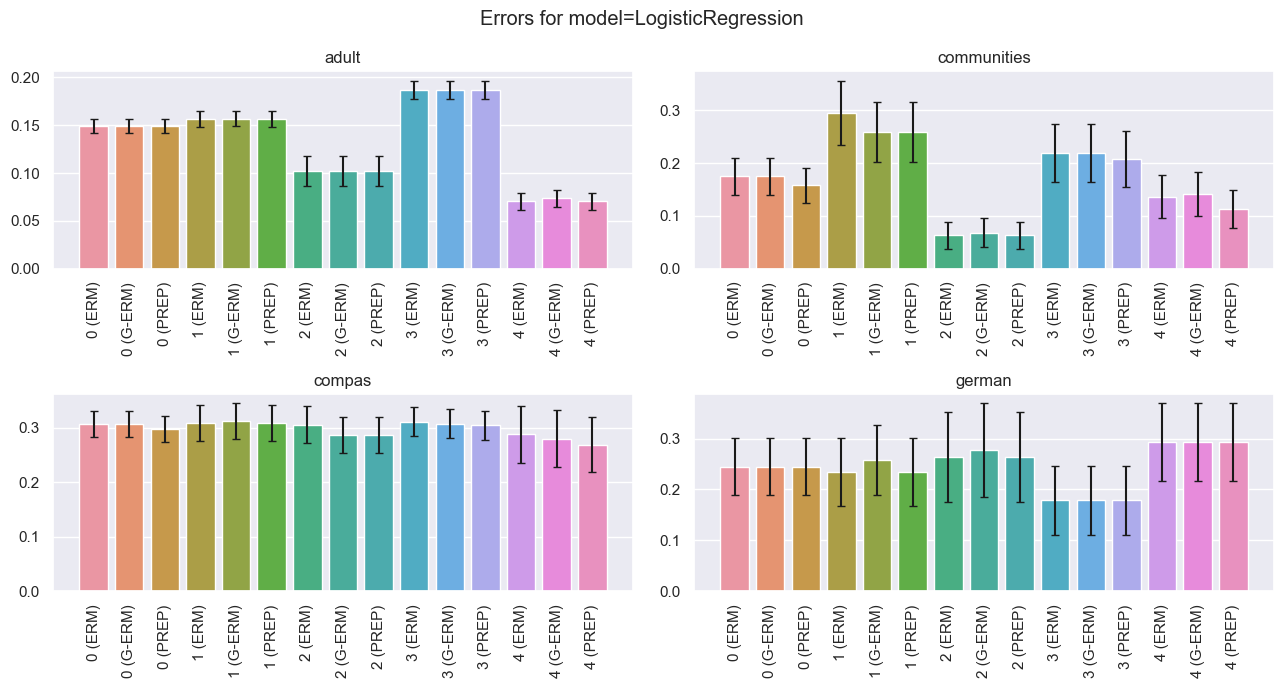

In [13]:
# Plot for each model
# Small datasets
model = MODELS[0]
fig, axs = plt.subplots(2, 2, figsize=(13, 7), )
fig.suptitle("Errors for model={}".format(model))
indices = itertools.product([0, 1], [0, 1])

for dataset, (i,j) in zip(small_datasets, indices):
    data = small_model_dfs_error[model].loc[dataset]
    errs = small_model_dfs_error[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i][j], x=data.index, y=data.values)
    axs[i][j].set_title(dataset)
    axs[i][j].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
    axs[i][j].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

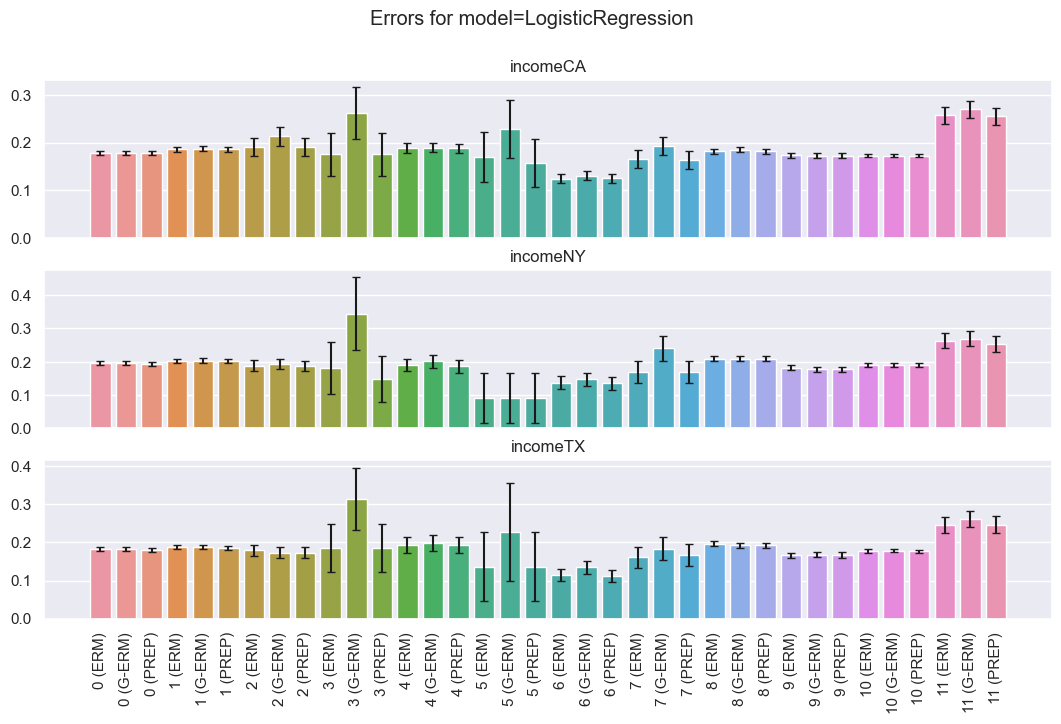

In [14]:
# Large datasets
fig, axs = plt.subplots(3, 1, figsize=(13, 7))
fig.suptitle("Errors for model={}".format(model))
income_datasets = big_datasets[:3]
employment_datasets = big_datasets[3:6]
coverage_datasets = big_datasets[6:9]

plt.xticks(rotation=90)
for i, dataset in enumerate(income_datasets):
    data = big_model_dfs_error[model].loc[dataset]
    errs = big_model_dfs_error[model].loc["{}_err".format(dataset)]
    sns.barplot(ax=axs[i], x=data.index, y=data.values)
    axs[i].set_title(dataset)
    axs[i].errorbar(x=data.index, y=data.values, yerr=errs, 
                       fmt="none", c="k", capsize=3)
    if i < 2:
        axs[i].set(xticklabels=[])
plt.show()

## Plot: Errors for fixed dataset

In [159]:
def plot_error(ax, name, data, models, groups, title=None):
    # Preprocess the data into a vertical DF
    rows = []
    for (group, model) in itertools.product(groups, models):
        row = {}
        row['group'] = group
        row['model'] = model
        row['error'] = data.loc[group][model]
        err = data.loc[group]["{} err".format(model)]
        lerr = err
        uerr = min([1.0 - data.loc[group][model], err])
        row['lerr'] = lerr
        row['uerr'] = uerr
        rows.append(row)

    df = pd.DataFrame(rows)

    # Plot the data
    err = []
    lerr = df.pivot(index='group', columns='model', values='lerr')
    uerr = df.pivot(index='group', columns='model', values='uerr')
    for col in lerr:
        err.append([lerr[col].values, uerr[col].values])
    p = df.pivot(index='group', columns='model', values='error')
    p = p.rename(index={'0': 'ALL'})
    if 'RandomForest2 (ERM)' in models:
        p = p.rename(columns={'RandomForest2 (ERM)': 'RandomForest (ERM)'})
    if 'RandomForest4 (ERM)' in models:
        p = p.rename(columns={'RandomForest4 (ERM)': 'RandomForest (ERM)'})
    if 'RandomForest8 (ERM)' in models:
        p = p.rename(columns={'RandomForest8 (ERM)': 'RandomForest (ERM)'})
    if 'RandomForest16 (ERM)' in models:
        p = p.rename(columns={'RandomForest16 (ERM)': 'RandomForest (ERM)'})
    ax = p.plot(kind='bar', yerr=err, ax=plt.gca())
    ax.set_ylabel('test error')
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Test Errors for {}".format(name))
    ax.legend(loc='center', frameon=False, bbox_to_anchor=(0, 0.5, 2.5, 0))
    return ax

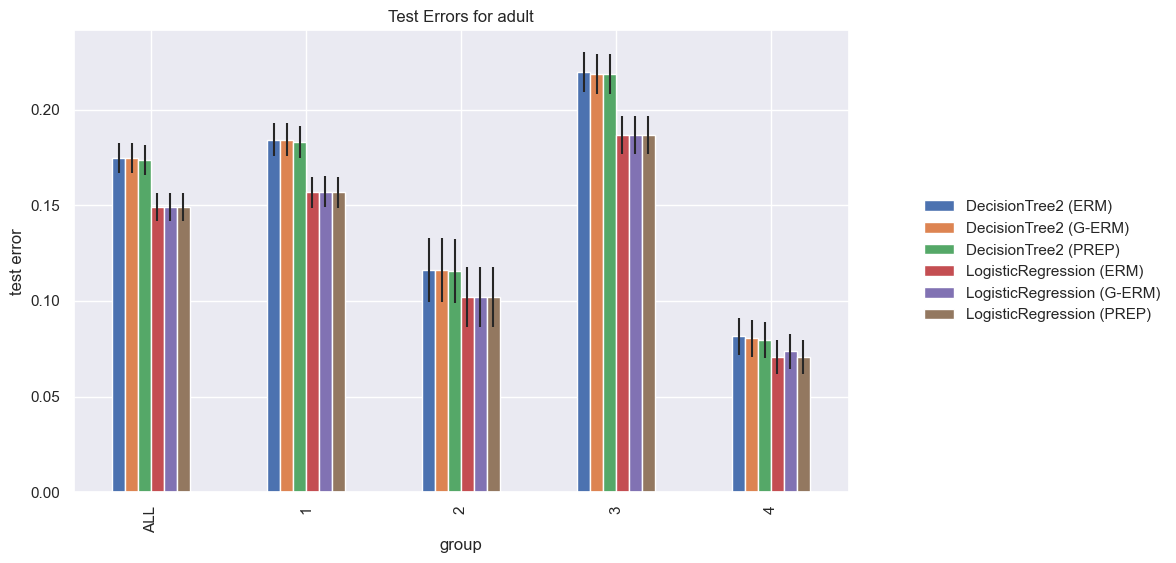

In [66]:
data = dataset_dfs_error['adult'].transpose()
groups = list(data.index)
models = ['LogisticRegression (ERM)', 'LogisticRegression (G-ERM)', 'LogisticRegression (PREP)', 'DecisionTree2 (ERM)', 'DecisionTree2 (G-ERM)', 'DecisionTree2 (PREP)']
fig, ax = plt.subplots(figsize=(10, 6))

ax = plot_error(ax, 'adult', data, models, groups)

# Final Plots

## Display 1: Agreement by varying model complexity
The first set of plots we show is that agreement goes up as we vary model
complexity. Of course, we'd expect this to be the case with Random Forests and
Decision Trees, but sometimes we get high agreement even with Logistic Regression
or (linear) SVM. This suggests that the multi-group setting for these datasets
with high agreement even with just linear models should be easy.

### Plot 1A: All model types
In this plot, we go through all the models from parametric to nonparametric.

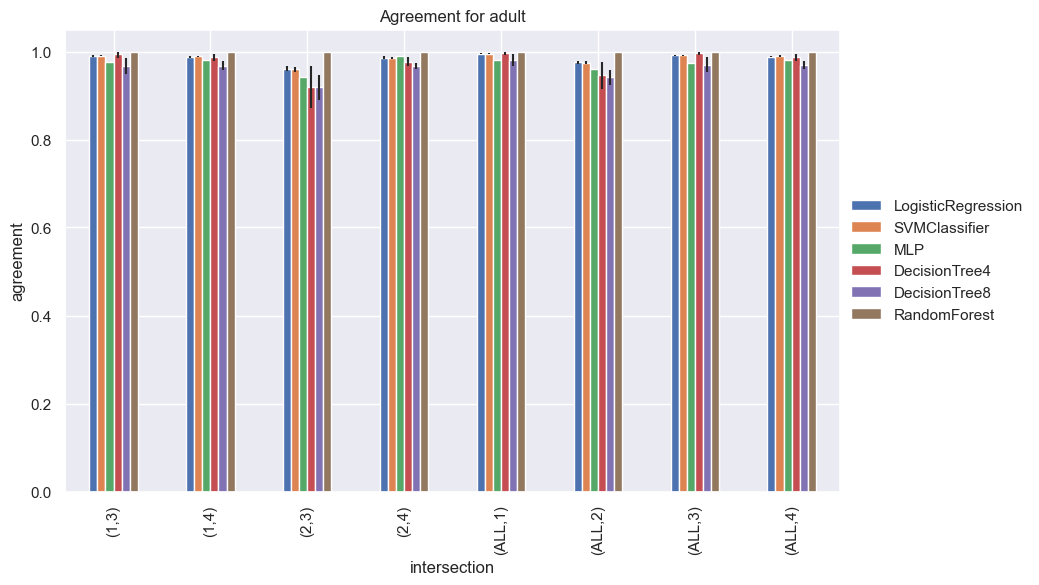

In [130]:
# Dataset: Adult
DATASET = 'adult'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

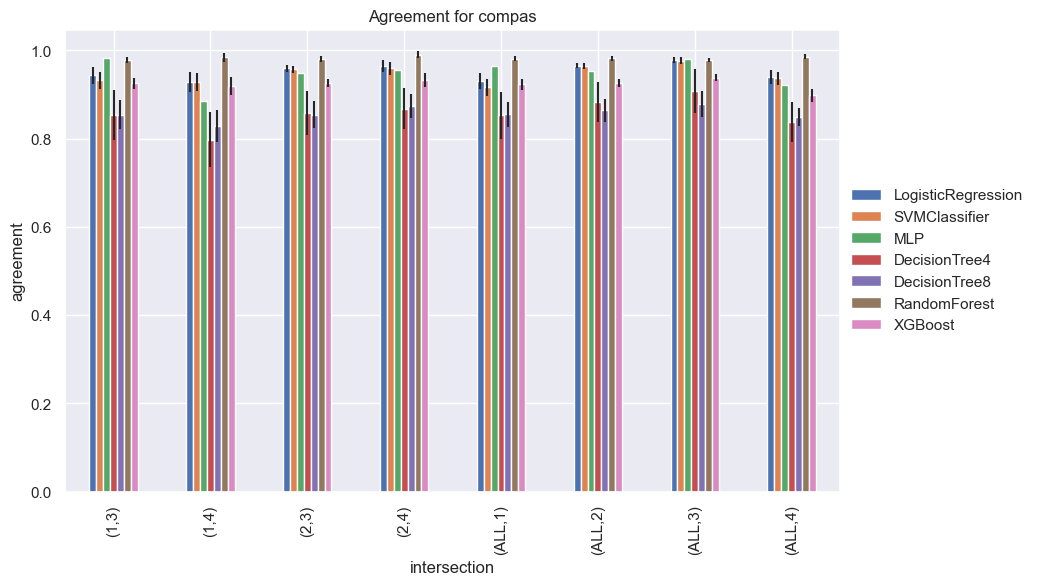

In [131]:
# Dataset: COMPAS
DATASET = 'compas'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
    'XGBoost',
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

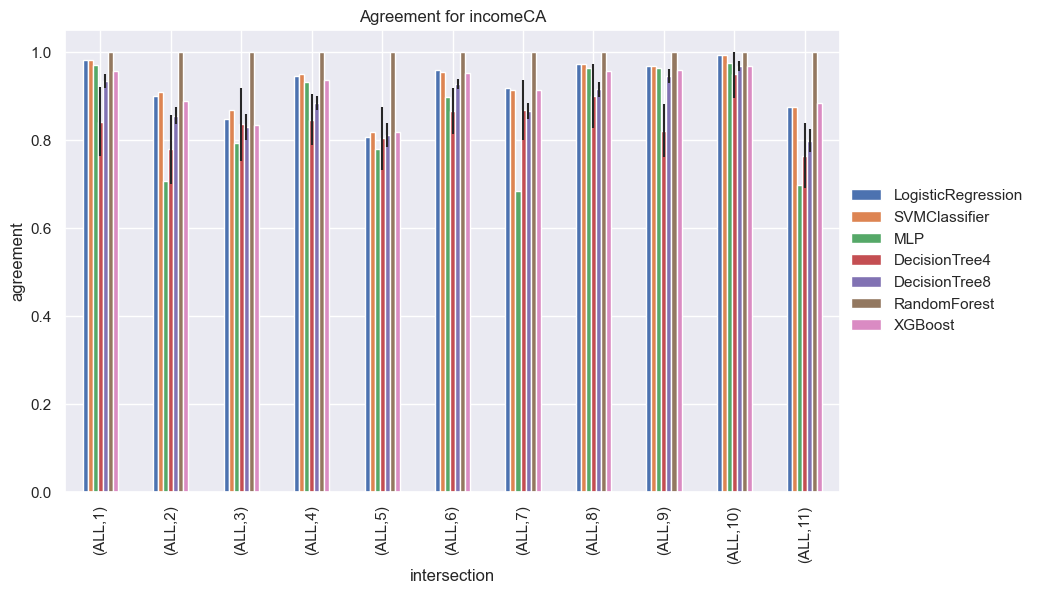

In [132]:
# Dataset: IncomeCA
DATASET = 'incomeCA'

models = [
    'LogisticRegression',
    'SVMClassifier',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
    'XGBoost',
]

data = dataset_dfs_agree[DATASET].transpose()
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, ALL_INTERSECTIONS)
plt.show()

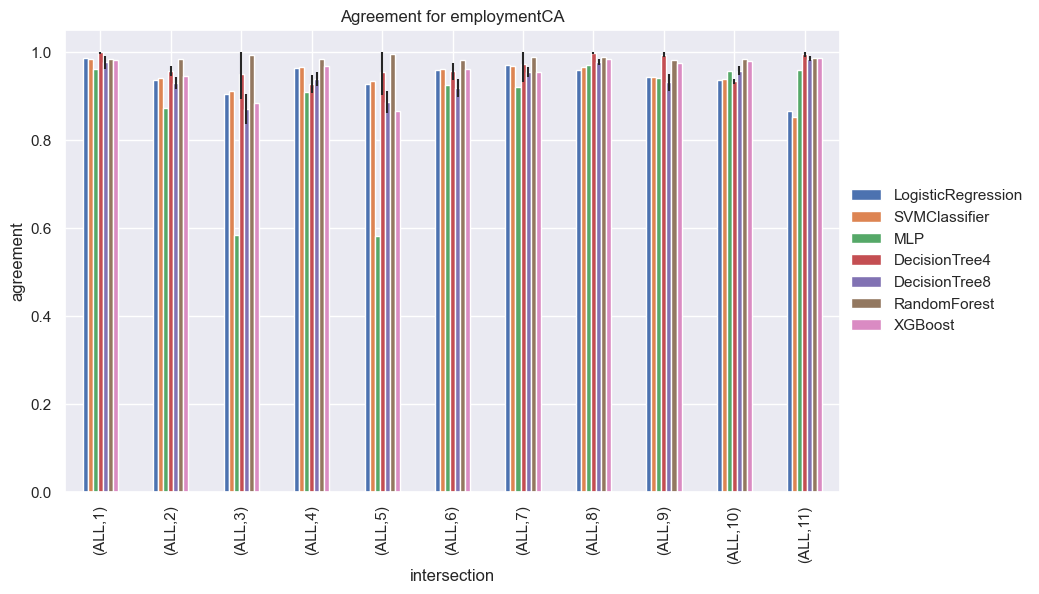

In [133]:
# Dataset: IncomeCA
DATASET = 'employmentCA'

models = [
    'LogisticRegression',
    'SVMClassifier',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
    'XGBoost',
]

data = dataset_dfs_agree[DATASET].transpose()
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, ALL_INTERSECTIONS)
plt.show()

### Plot 1B: DecisionTree (varying depth)

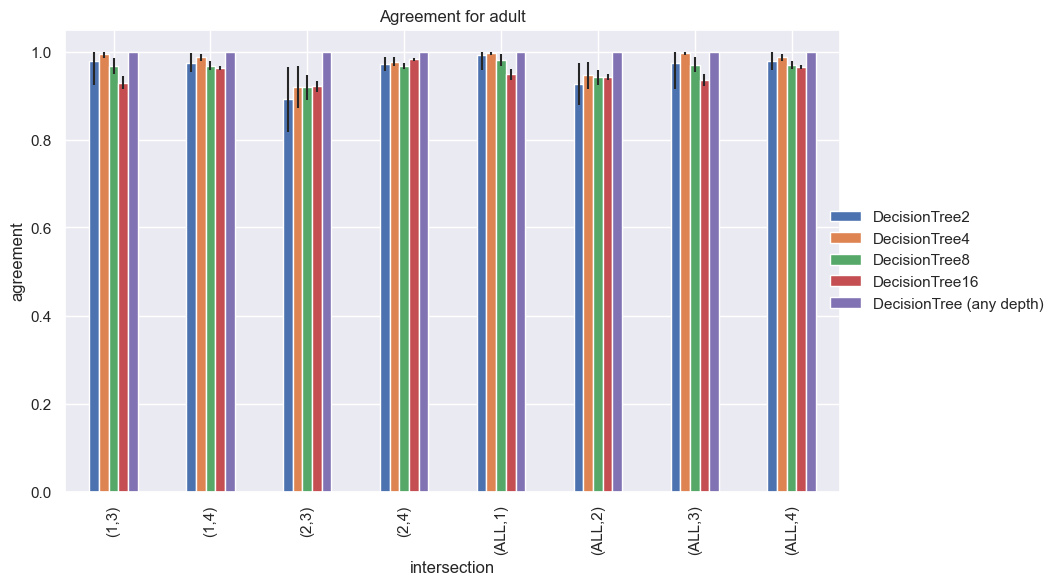

In [134]:
# Dataset: Adult
DATASET = 'adult'
models = [
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

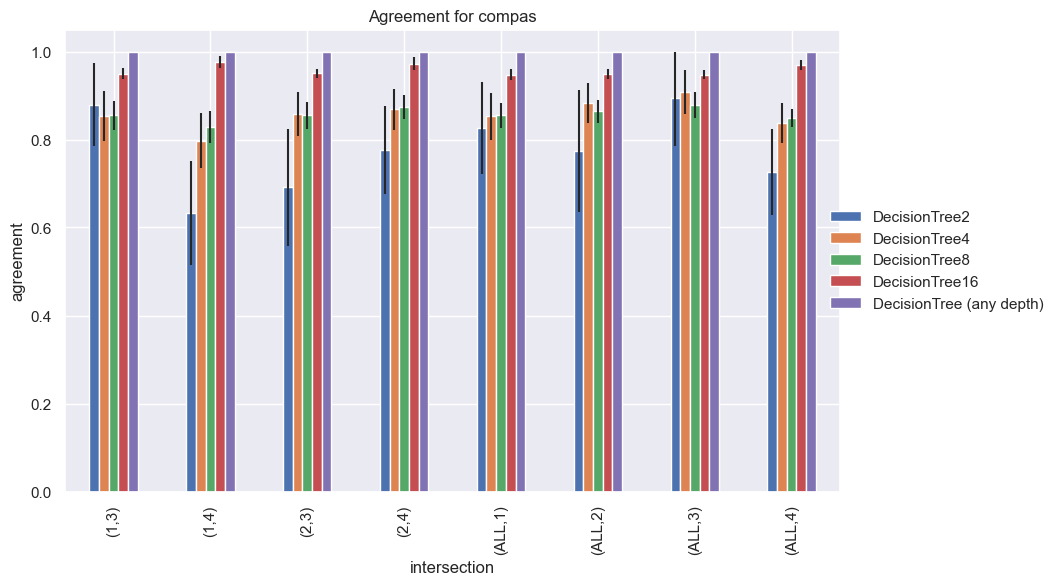

In [135]:
# Dataset: Adult
DATASET = 'compas'
models = [
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

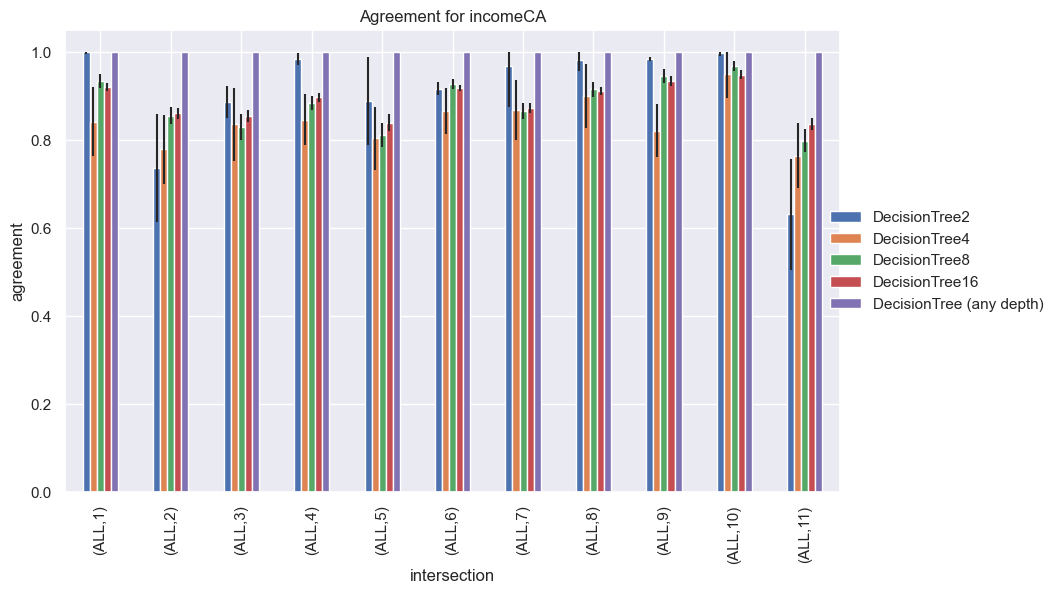

In [137]:
# Dataset: IncomeCA
DATASET = 'incomeCA'
models = [
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree'
]

data = dataset_dfs_agree[DATASET].transpose()
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, ALL_INTERSECTIONS)
plt.show()

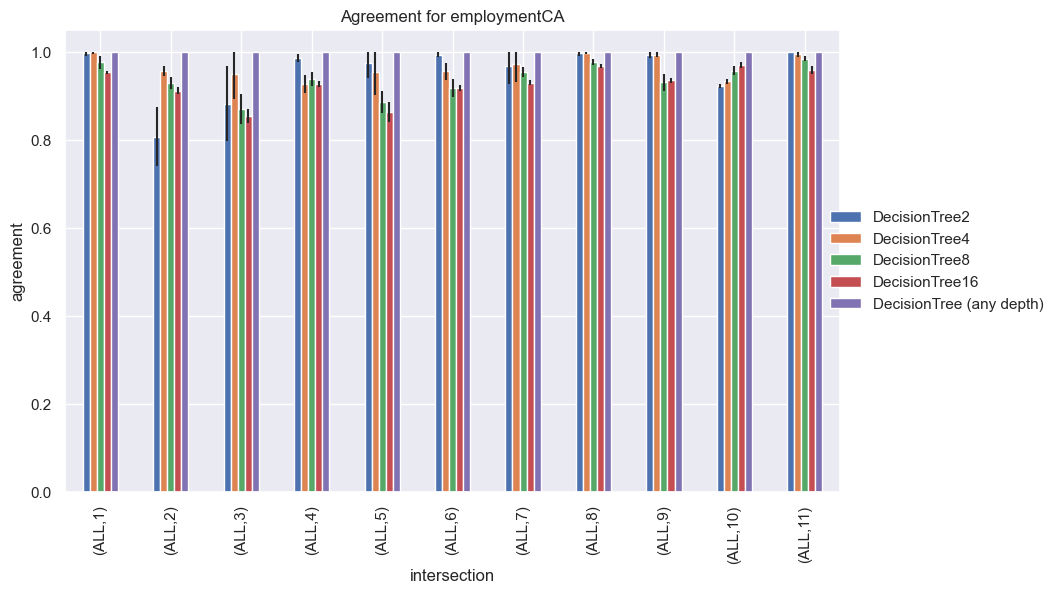

In [138]:
# Dataset: IncomeCA
DATASET = 'employmentCA'
models = [
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree'
]

data = dataset_dfs_agree[DATASET].transpose()
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, ALL_INTERSECTIONS)
plt.show()

## Display 2: Ensembles vs. ERM (Small Datasets)
The main conjecture is: when we can achieve high agreement with a simple model class,
good group-wise error comes for free with just ERM over the entire dataset. When we have
low agreement with that model class, we should see that ERM with that model class
is outperformed by more complicated ensembles and group minimax methods like Prepend.

That is, there are case where low agreement necessitates something *better* than
simply doing global ERM. However, when we have high agreement, a more complicated
ensemble method could be replaced by just doing global ERM.

### Plot 2A: Adult (High agreement, ERM is sufficient)

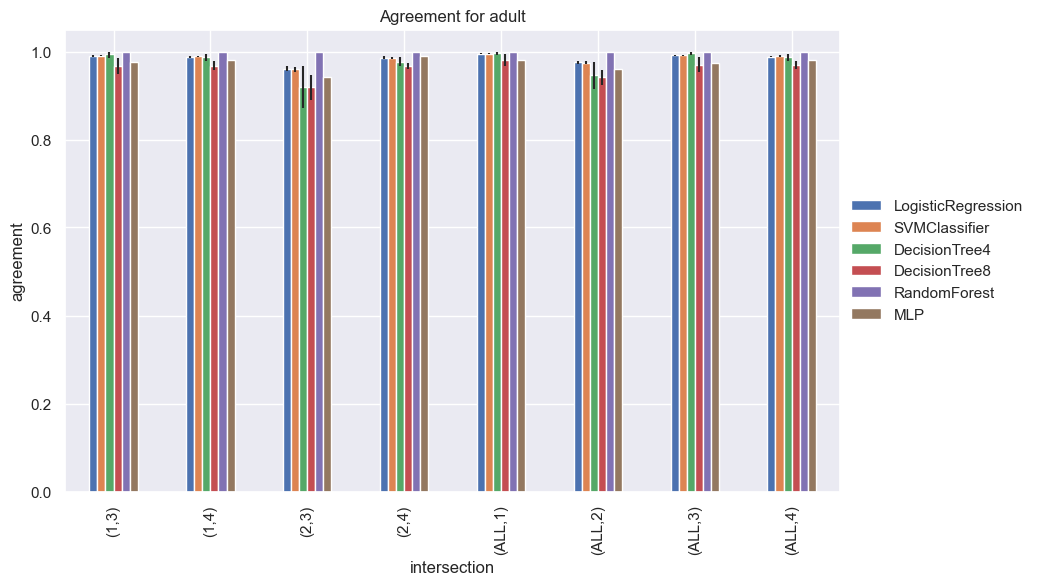

In [144]:
# Dataset: Adult
DATASET = 'adult'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
    'MLP'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

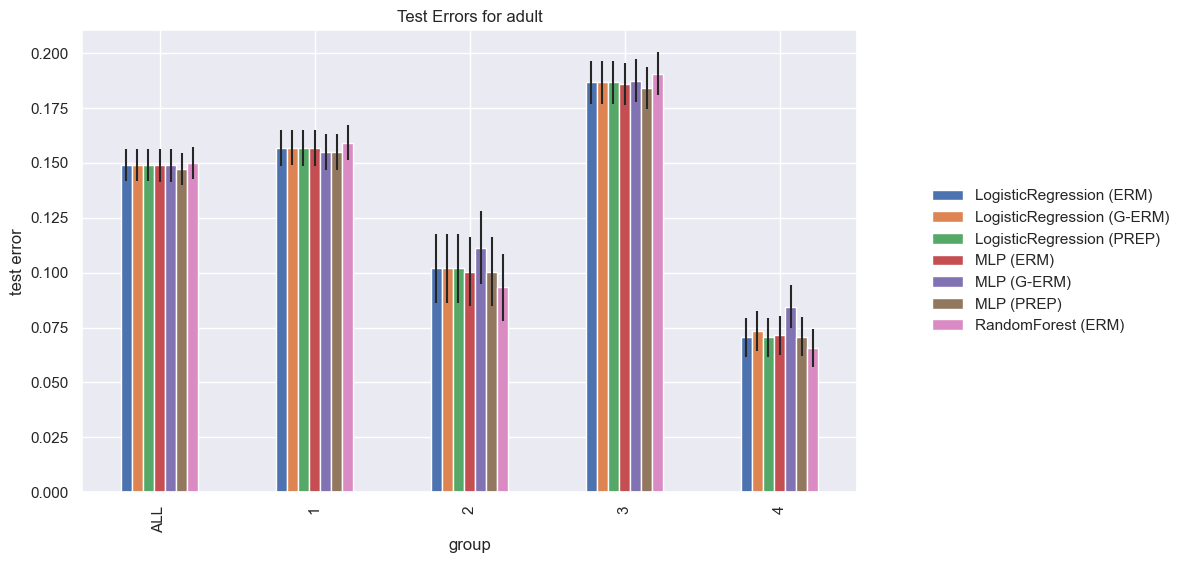

In [145]:
# Dataset: Adult
DATASET = 'adult'
models = [
    'LogisticRegression (ERM)',
    'LogisticRegression (G-ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)'
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, 'adult', data, models, groups)

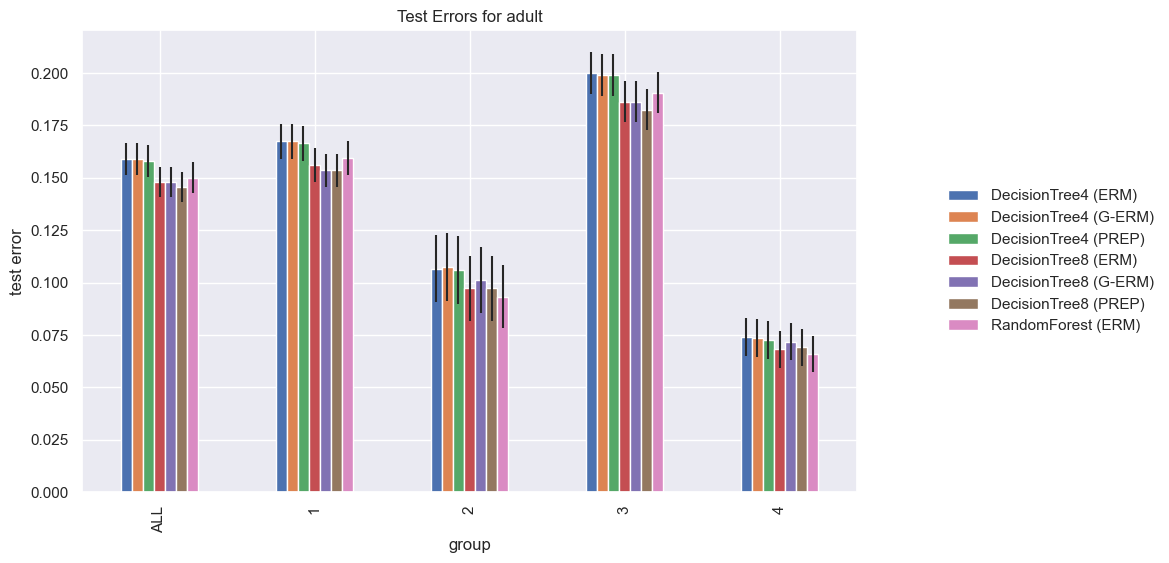

In [146]:
# Dataset: Adult
DATASET = 'adult'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (G-ERM)',
    'DecisionTree4 (PREP)',
    'DecisionTree8 (ERM)',
    'DecisionTree8 (G-ERM)',
    'DecisionTree8 (PREP)',
    'RandomForest (ERM)',
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, 'adult', data, models, groups)

### Plot 2B: Communities (Lower Agreement, Need Ensemble)
In this example, the MLP classifier has particularly bad agreement, and we see
that ensembling the MLP classifier with Prepend yields a significant improvement.


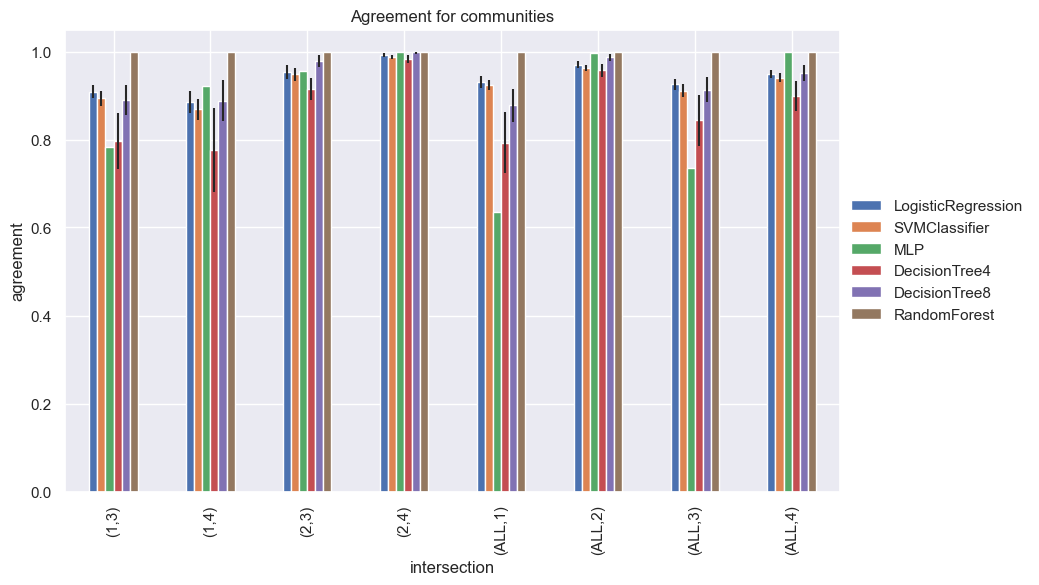

In [160]:
# Dataset: communities
DATASET = 'communities'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

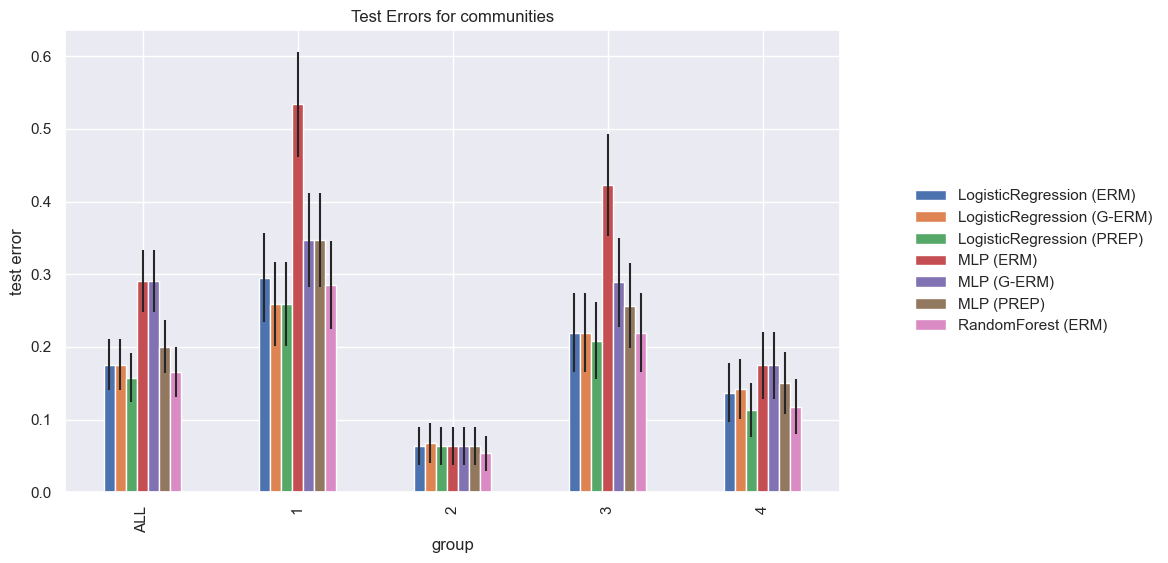

In [161]:
# Dataset: Communities
DATASET = 'communities'
models = [
    'LogisticRegression (ERM)',
    'LogisticRegression (G-ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)'
]


data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, DATASET, data, models, groups)

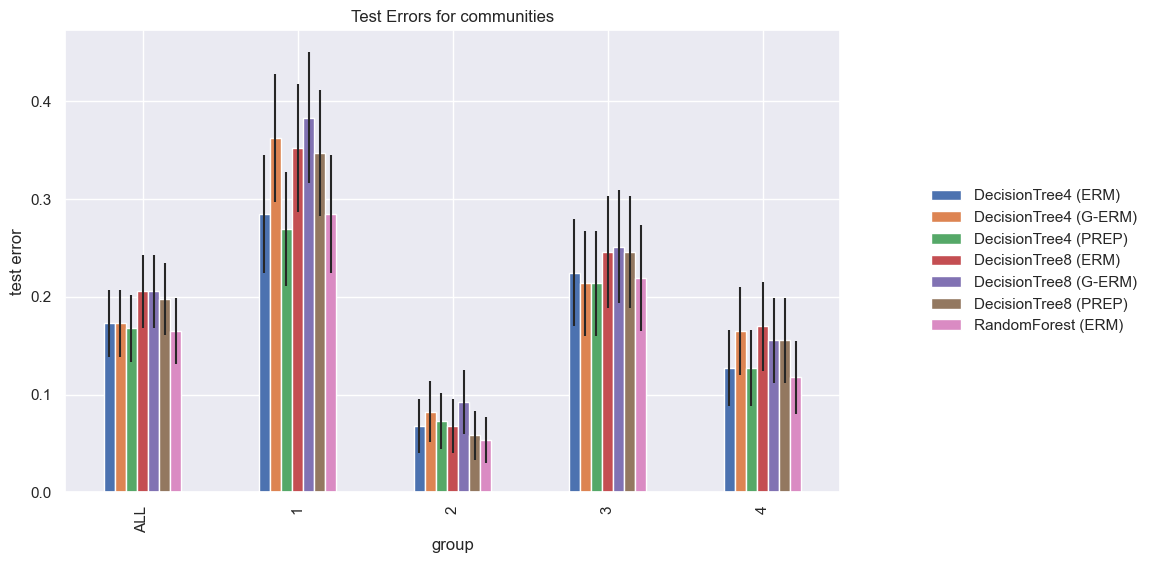

In [162]:
# Dataset: Communities
DATASET = 'communities'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (G-ERM)',
    'DecisionTree4 (PREP)',
    'DecisionTree8 (ERM)',
    'DecisionTree8 (G-ERM)',
    'DecisionTree8 (PREP)',
    'RandomForest (ERM)',
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, DATASET, data, models, groups)

### Plot 2C: German (Lower Agreement, Need Ensemble)

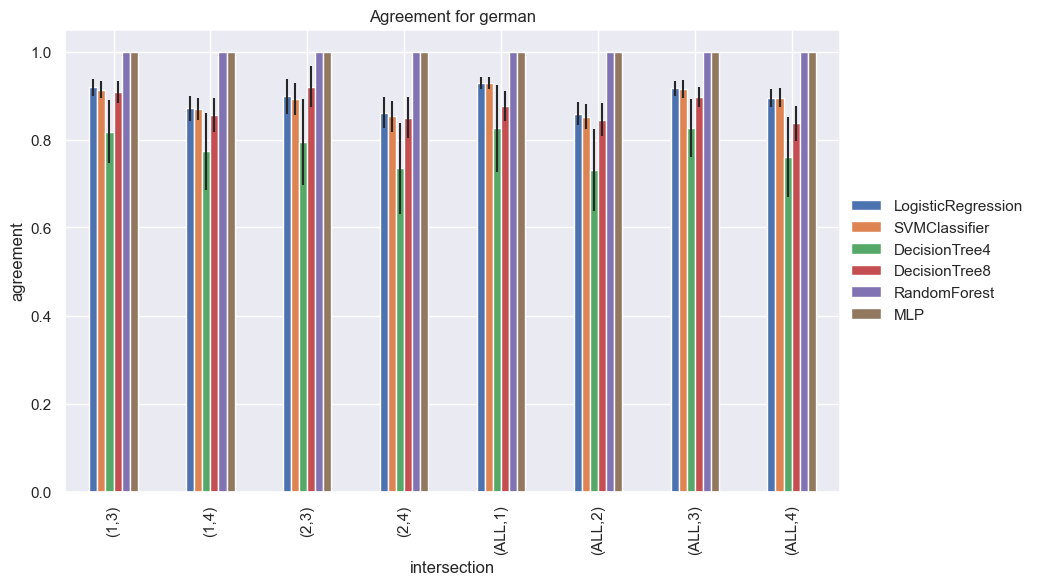

In [163]:
# Dataset: german
DATASET = 'german'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
    'MLP'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

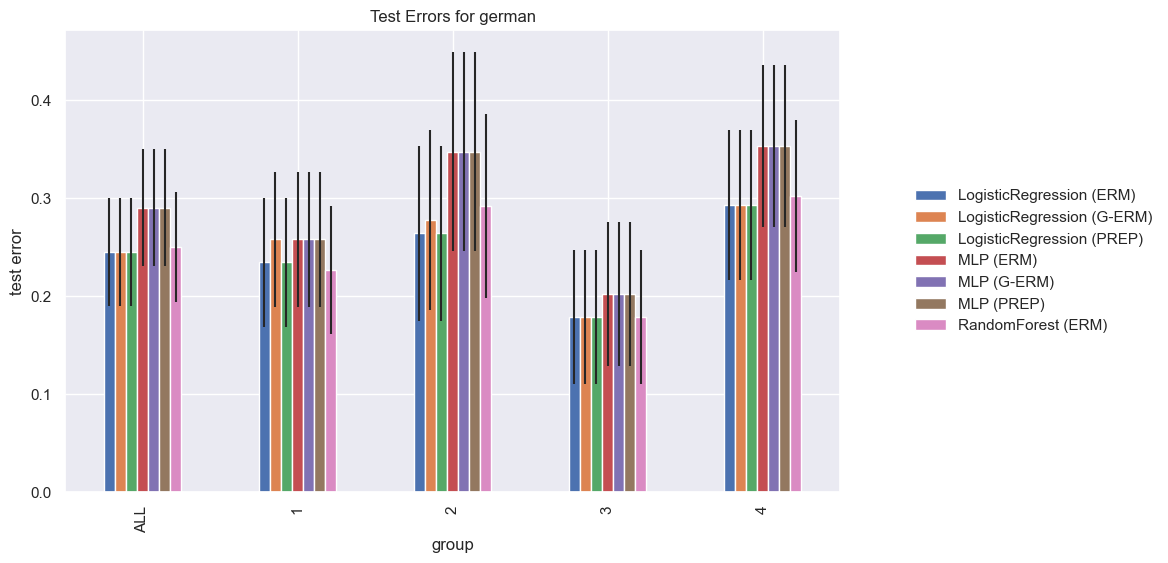

In [164]:
# Dataset: Communities
DATASET = 'german'
models = [
    'LogisticRegression (ERM)',
    'LogisticRegression (G-ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)'
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, DATASET, data, models, groups)

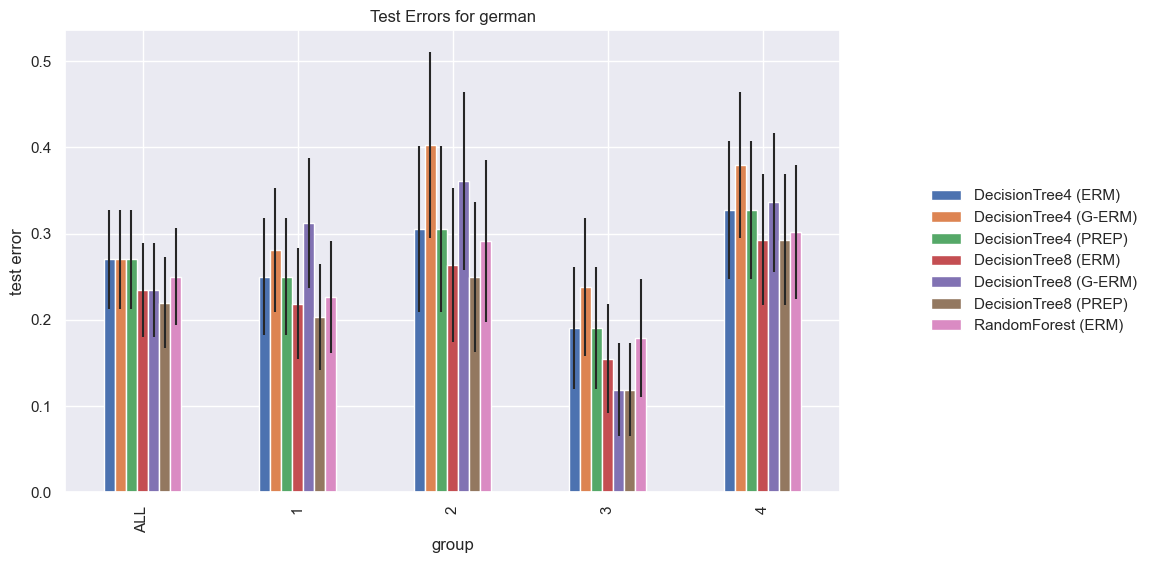

In [165]:
# Dataset: Communities
DATASET = 'german'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (G-ERM)',
    'DecisionTree4 (PREP)',
    'DecisionTree8 (ERM)',
    'DecisionTree8 (G-ERM)',
    'DecisionTree8 (PREP)',
    'RandomForest (ERM)',
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, DATASET, data, models, groups)

### Plot 2D: COMPAS

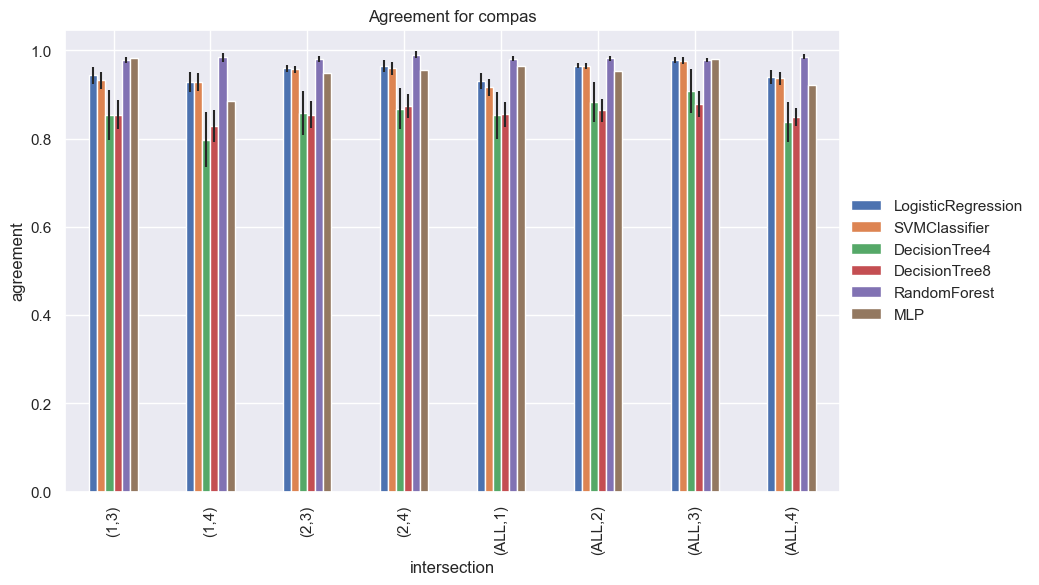

In [166]:
# Dataset: communities
DATASET = 'compas'
models = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree4',
    'DecisionTree8',
    'RandomForest',
    'MLP'
]

data = dataset_dfs_agree[DATASET].transpose()
intersections = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, intersections)
plt.show()

TypeError: rename() got an unexpected keyword argument 'column'

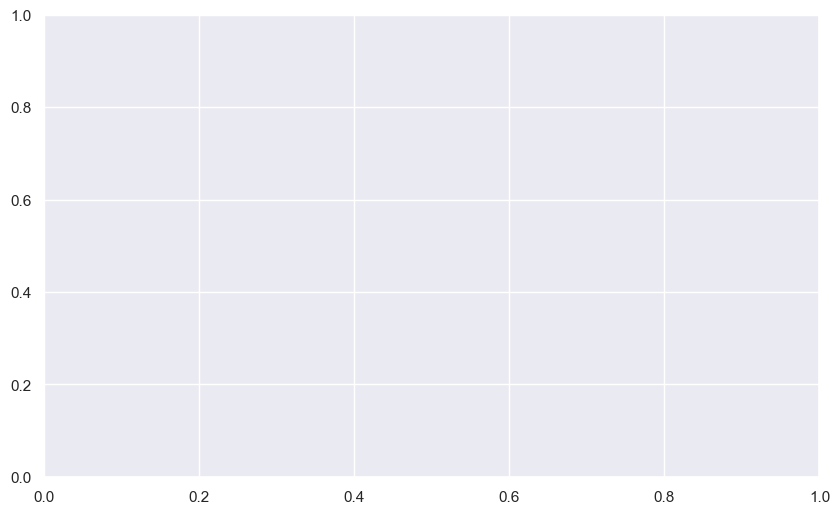

In [167]:
# Dataset: Communities
DATASET = 'compas'
models = [
    'LogisticRegression (ERM)',
    'LogisticRegression (G-ERM)',
    'LogisticRegression (PREP)',
    'RandomForest8 (ERM)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)'
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, DATASET, data, models, groups)

TypeError: rename() got an unexpected keyword argument 'column'

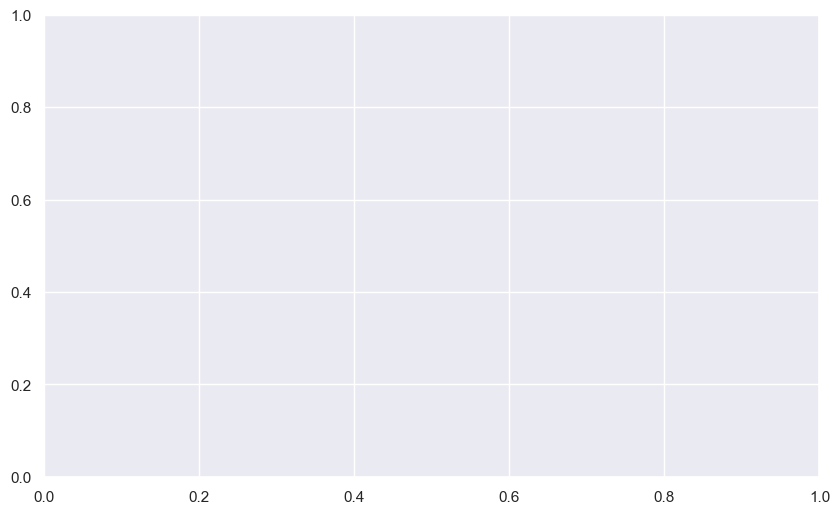

In [168]:
# Dataset: Communities
DATASET = 'compas'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (G-ERM)',
    'DecisionTree4 (PREP)',
    'DecisionTree8 (ERM)',
    'DecisionTree8 (G-ERM)',
    'DecisionTree8 (PREP)',
    'RandomForest8 (ERM)',
]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_error(ax, DATASET, data, models, groups)

## Display 3: Ensembles vs. ERM (Large Datasets)
Now we move onto the Folktables datasets. Throughout these datasets, we see that,
on groups with high agreement, it suffices to just use a simple ERM. On groups
with lower agreement, using Prepend, Random Forest, or XGBoost makes more sense.

We note that, for all the times we use MLP, the reason we see low agreement could
just be because there isn't sufficient data for training any reasonable model on
the groups with low agreement.

### Plot 3A: IncomeCA
For IncomeCA, we see that LogisticRegression and SVM already have high agreement
on the groups. We see that Prepend and ERM for these linear models perform similarly,
and, likewise, RandomForest performs similarly.

However, DecisionTree has low agreement, particularly on 2, 5, and 11.

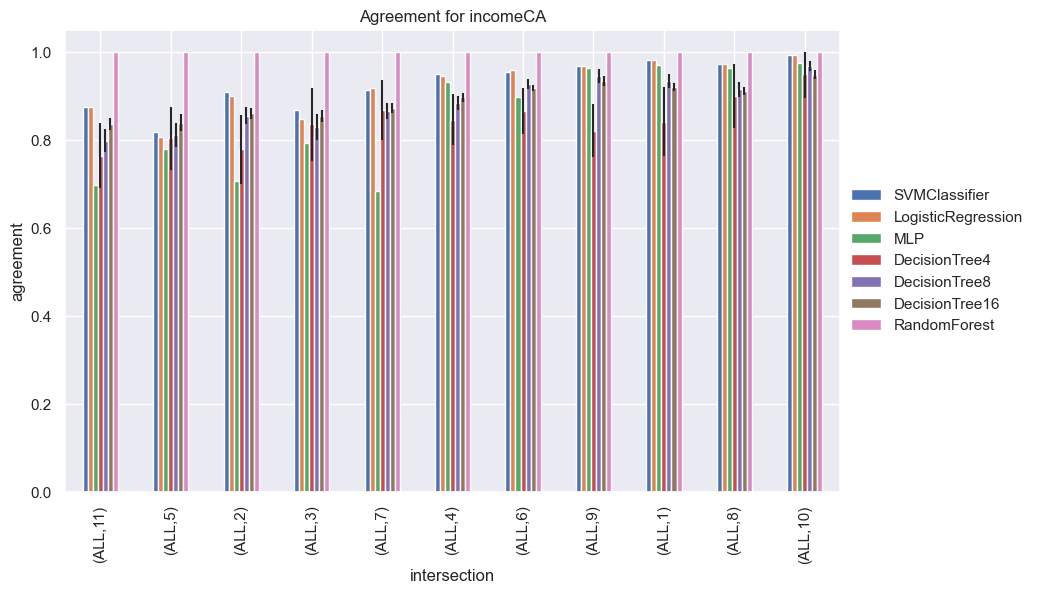

In [89]:
# Dataset: IncomeCA
DATASET = 'incomeCA'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

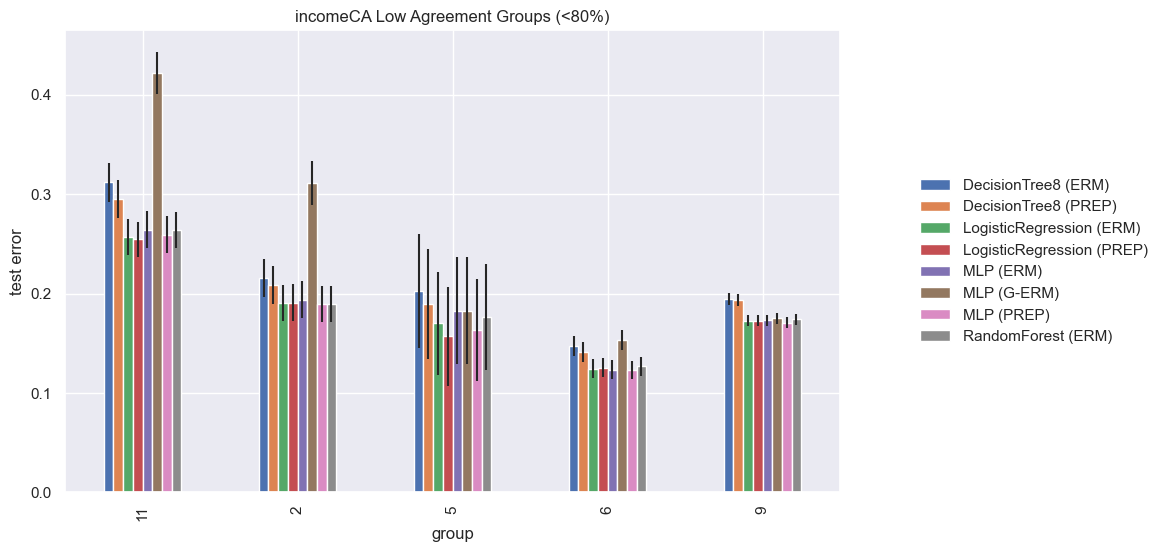

In [96]:
# Low agreement groups
DATASET = 'incomeCA'
models = [
    'DecisionTree8 (ERM)',
    'DecisionTree8 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["2", "5", "6", "9", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "incomeCA Low Agreement Groups (<80%)"
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

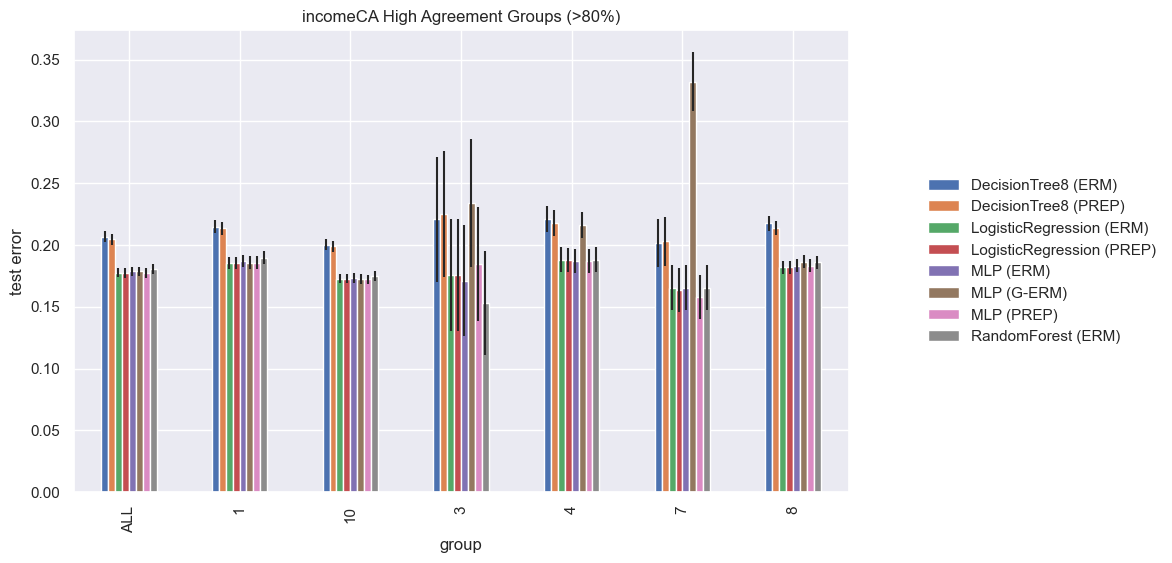

In [97]:
# High agreement groups
DATASET = 'incomeCA'
models = [
    'DecisionTree8 (ERM)',
    'DecisionTree8 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "incomeCA High Agreement Groups (>80%)"
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

### Plot 3B: IncomeNY and IncomeTX
Same story for IncomeNY and IncomeTX.

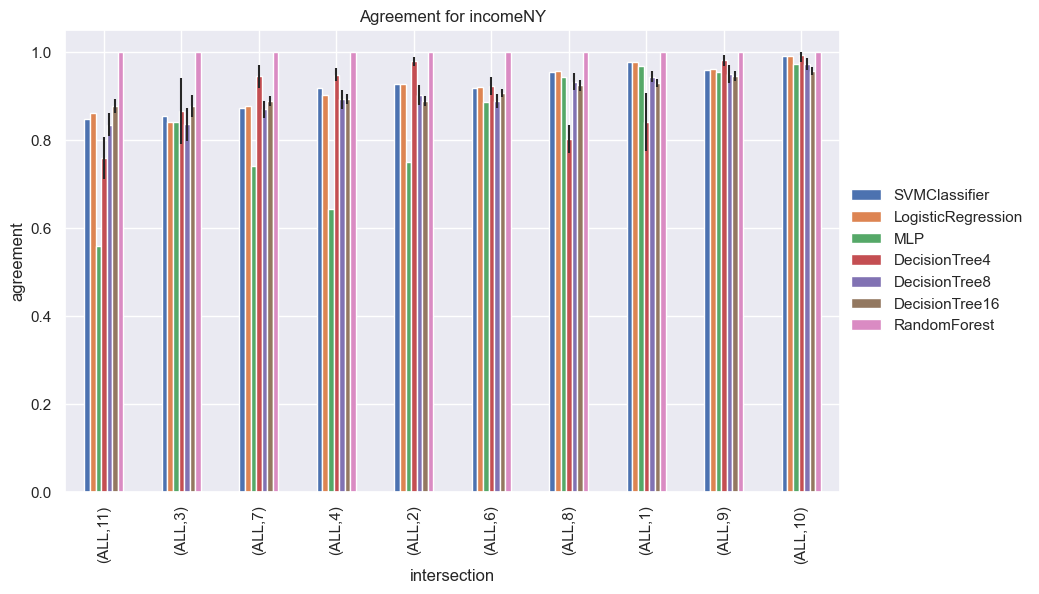

In [93]:
DATASET = 'incomeNY'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

data = dataset_dfs_agree[DATASET].transpose()
# (ALL, 5) has very few samples for NY
intersections_ny = sorted(list(set(ALL_INTERSECTIONS) - set(['(ALL,5)'])))
agree_list = list(data[models].sum(axis=1)[intersections_ny])
sorted_intersections = [intersections_ny[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

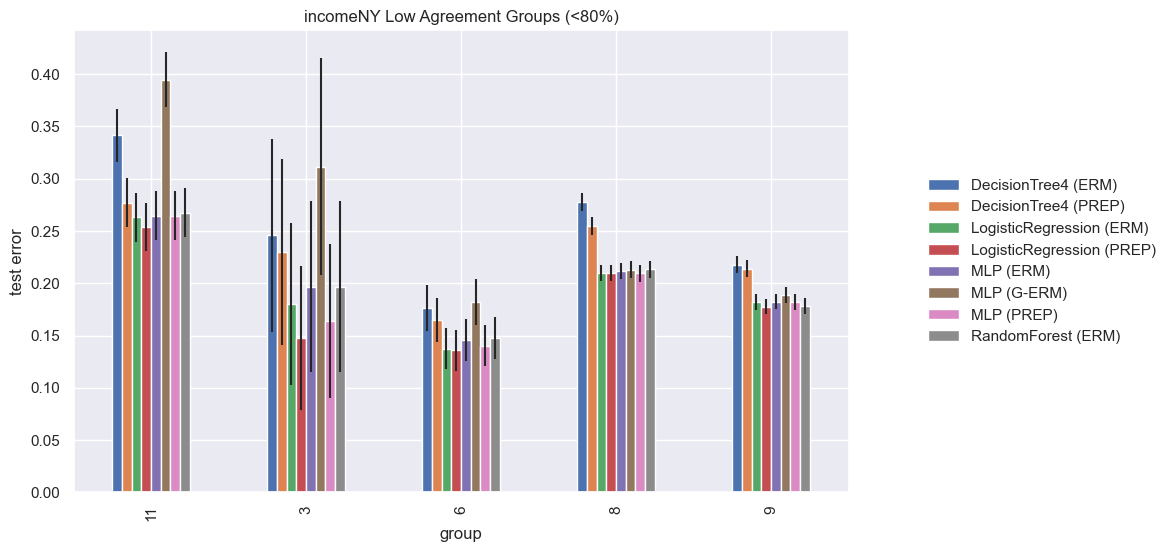

In [98]:
# Low agreement groups
DATASET = 'incomeNY'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "8", "6", "9", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

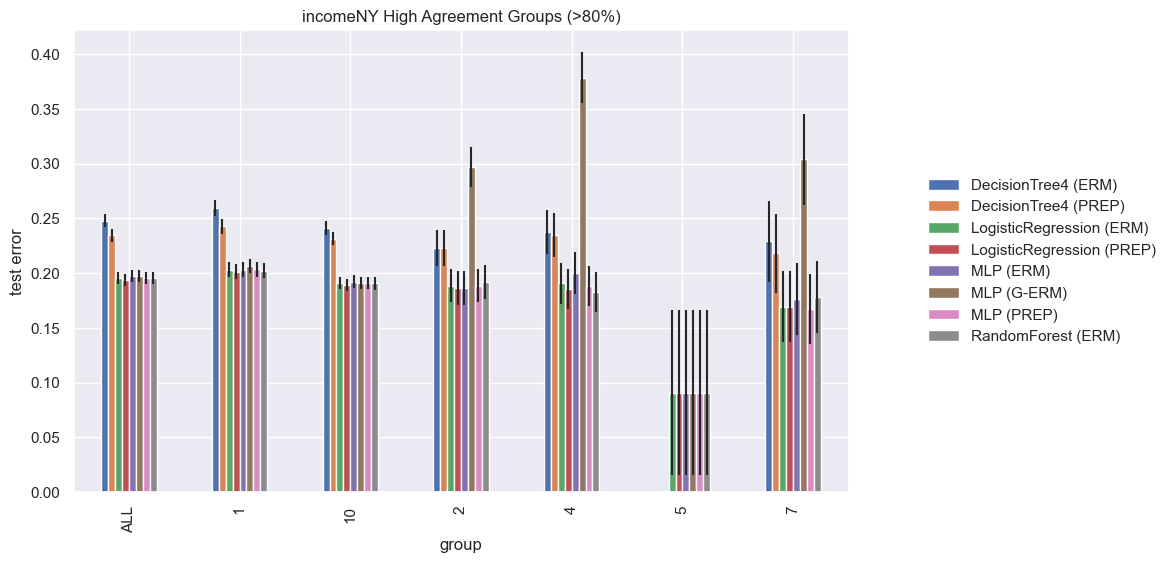

In [102]:
# High agreement groups
DATASET = 'incomeNY'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

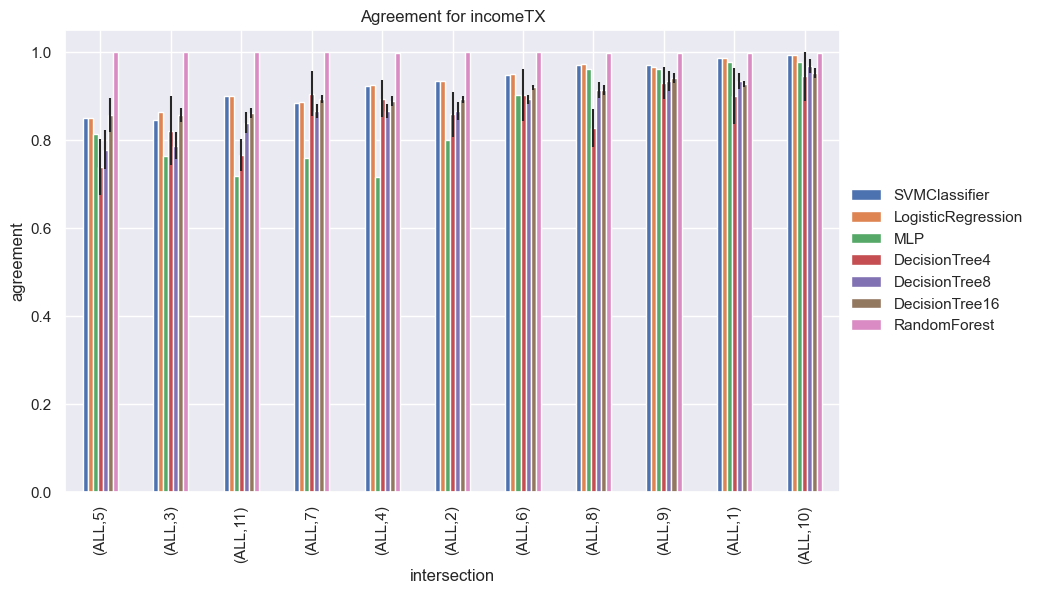

In [103]:
DATASET = 'incomeTX'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

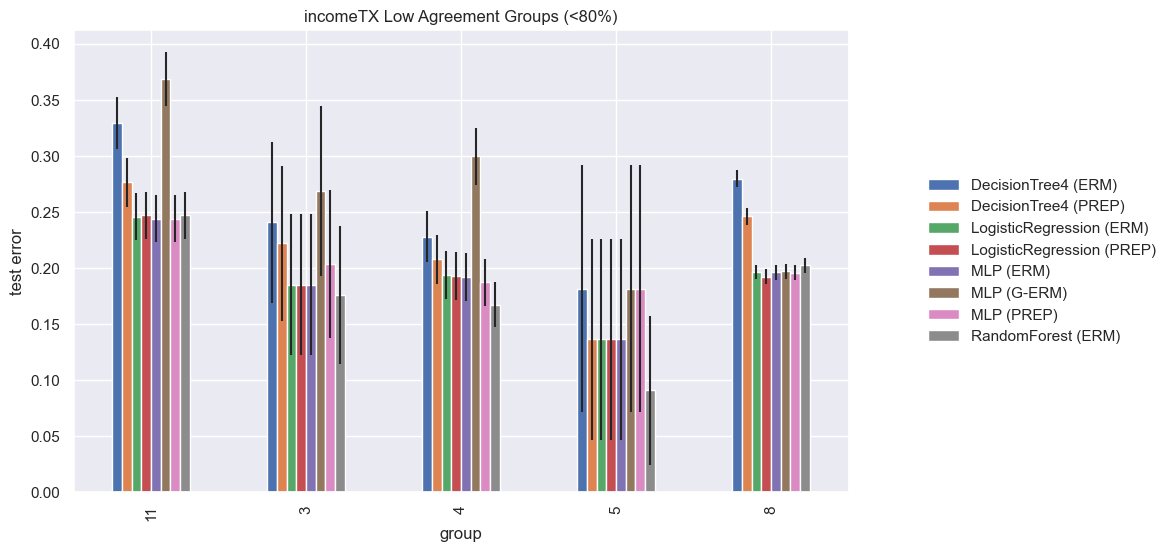

In [104]:
# Low agreement groups
DATASET = 'incomeTX'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "8", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

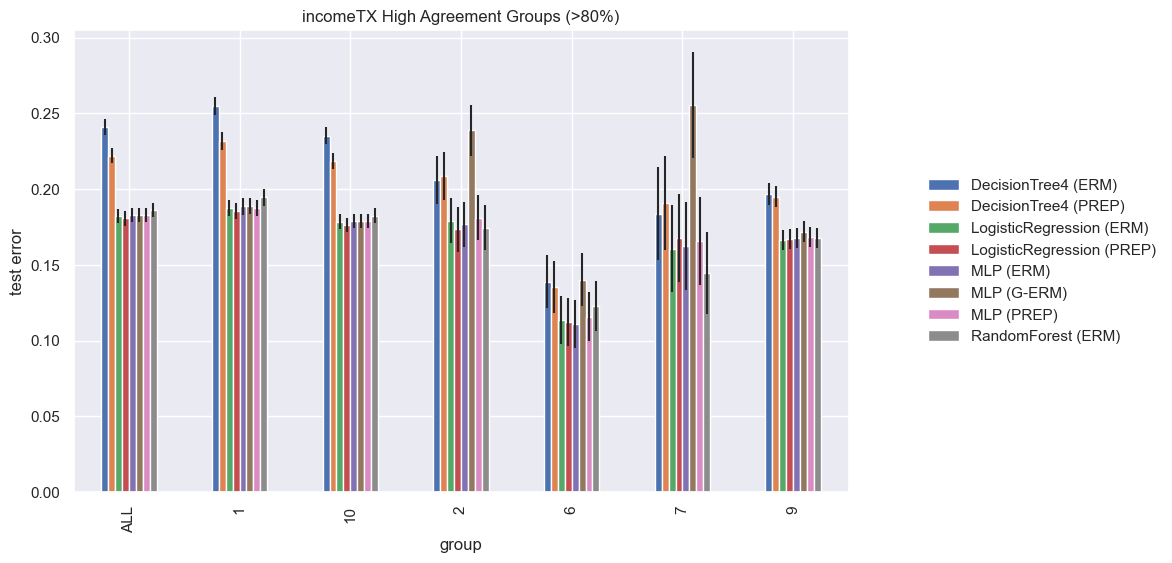

In [105]:
# High agreement groups
DATASET = 'incomeTX'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

### Part 3C: EmploymentCA

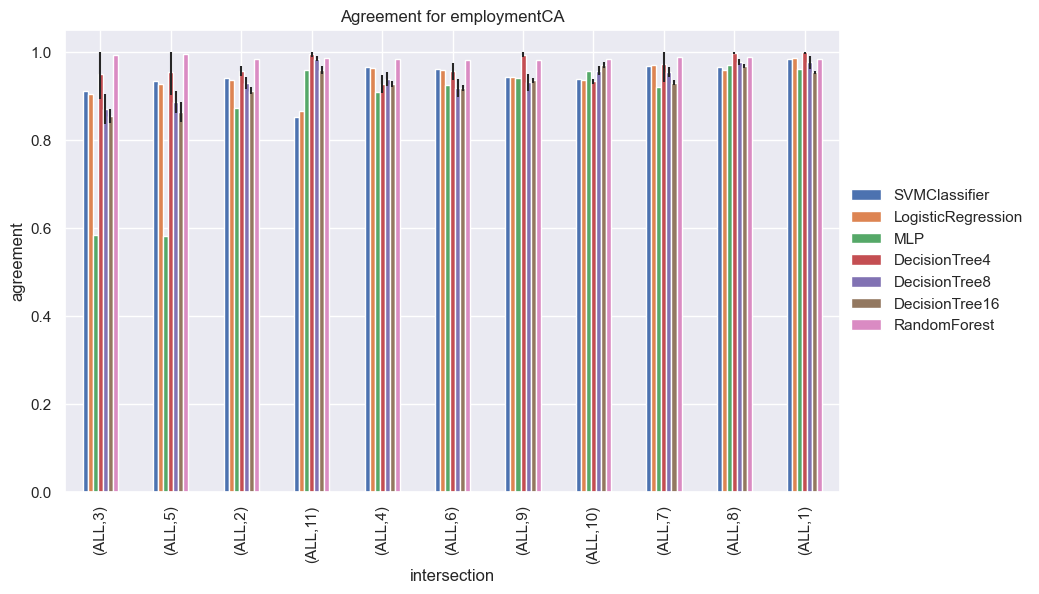

In [617]:
DATASET = 'employmentCA'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

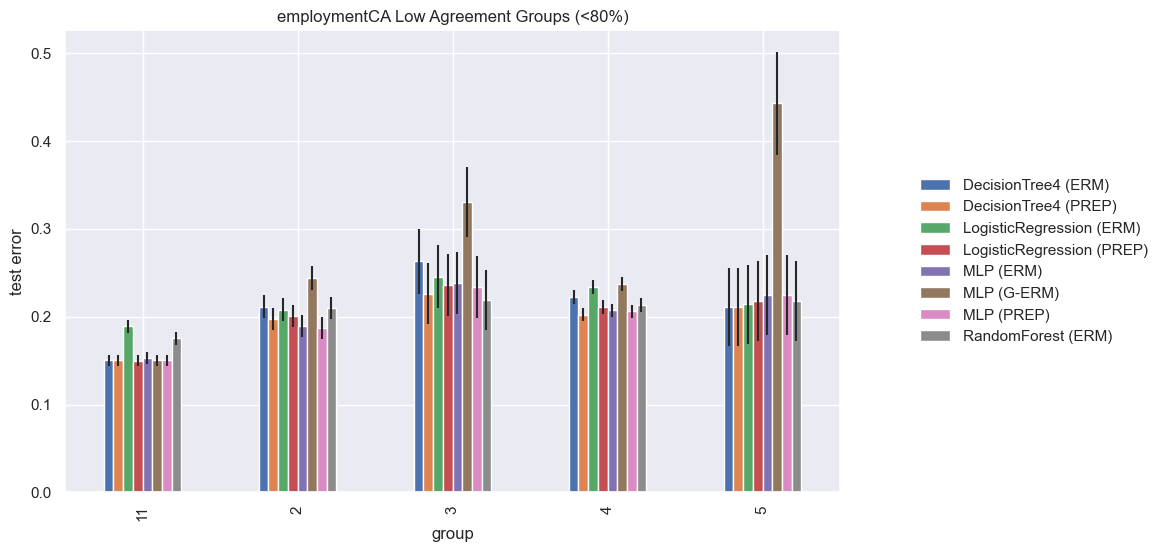

In [106]:
# Low agreement groups
DATASET = 'employmentCA'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "2", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

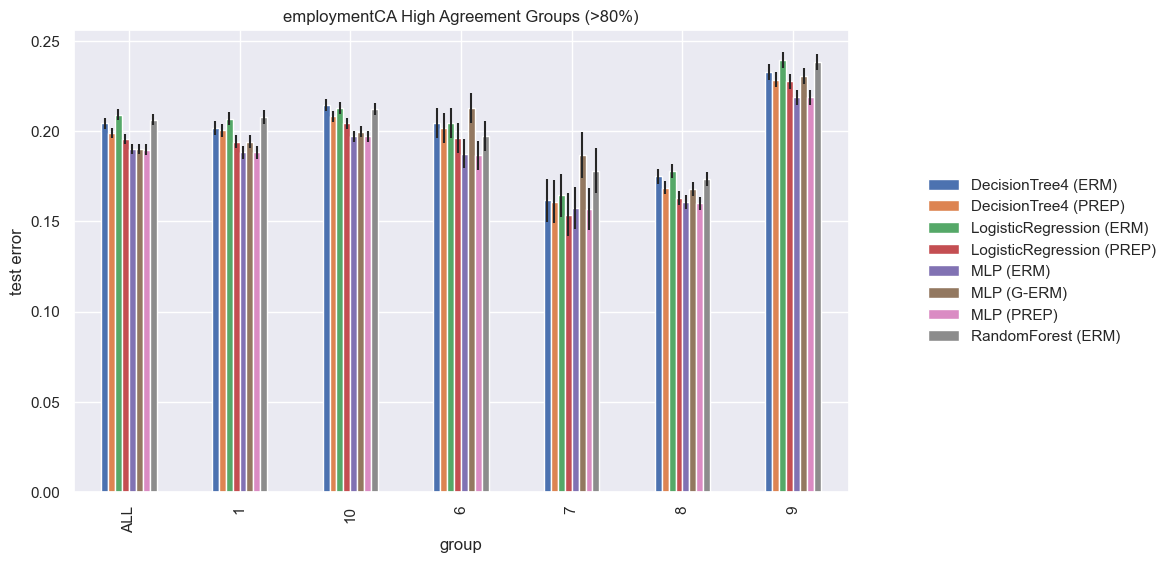

In [107]:
# High agreement groups
DATASET = 'employmentCA'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

### Part 3D: EmploymentNY and EmploymentTX

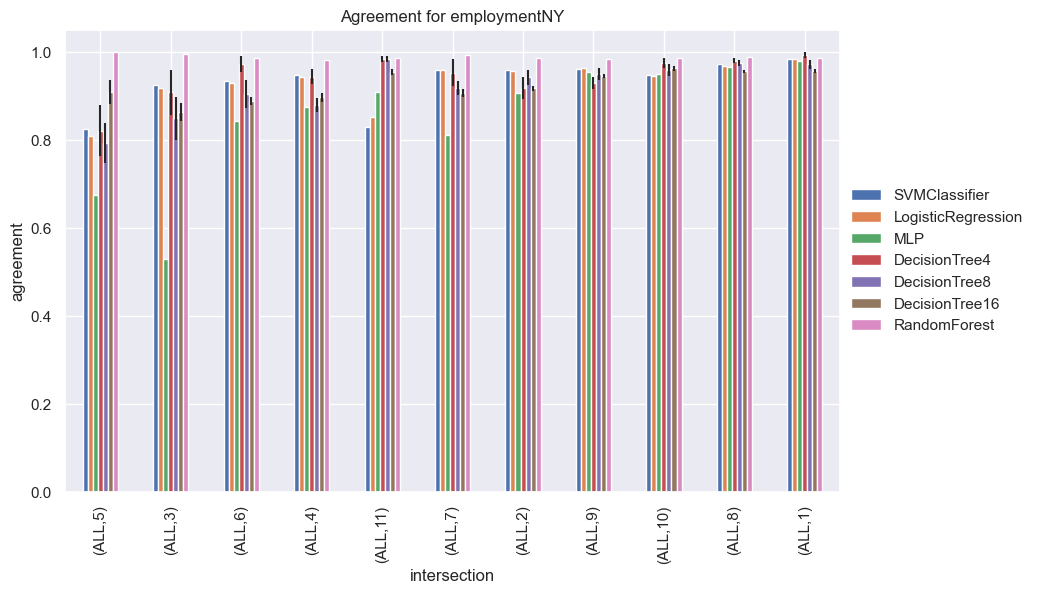

In [108]:
DATASET = 'employmentNY'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

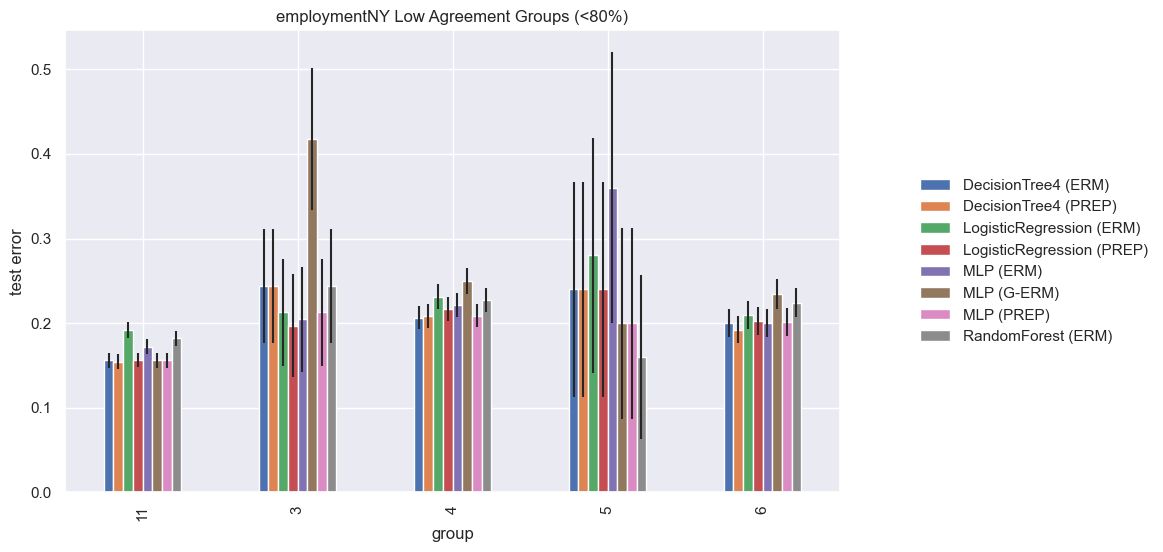

In [109]:
# Low agreement groups
DATASET = 'employmentNY'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "6", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

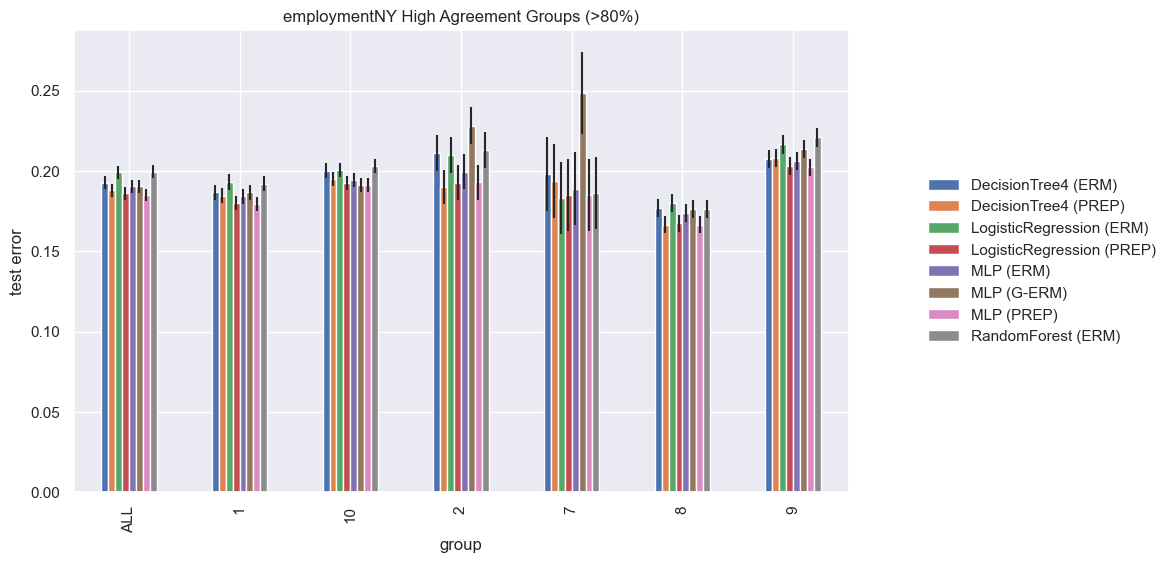

In [110]:
# High agreement groups
DATASET = 'employmentNY'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

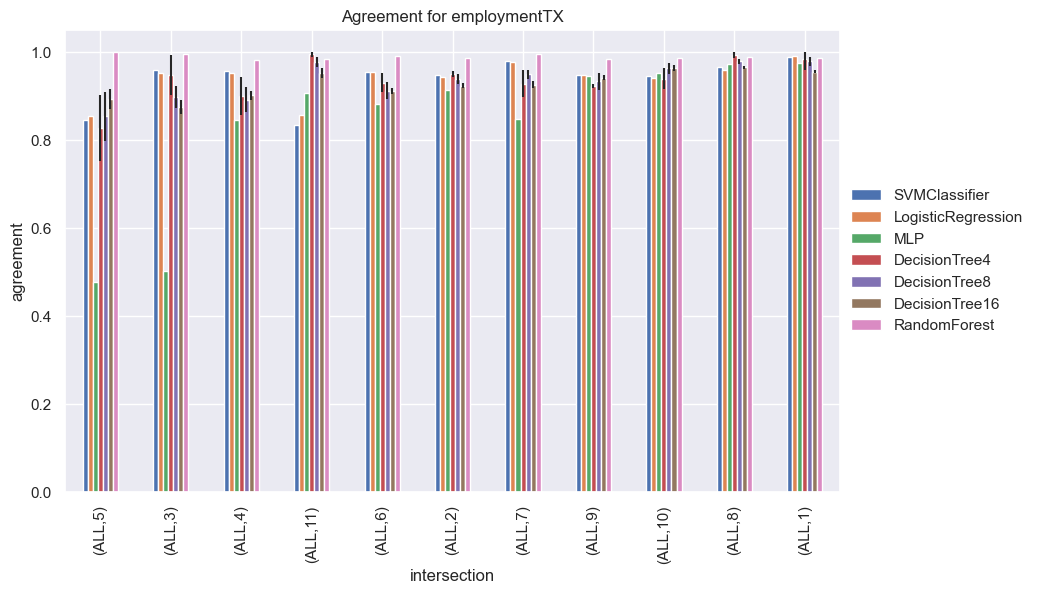

In [111]:
DATASET = 'employmentTX'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

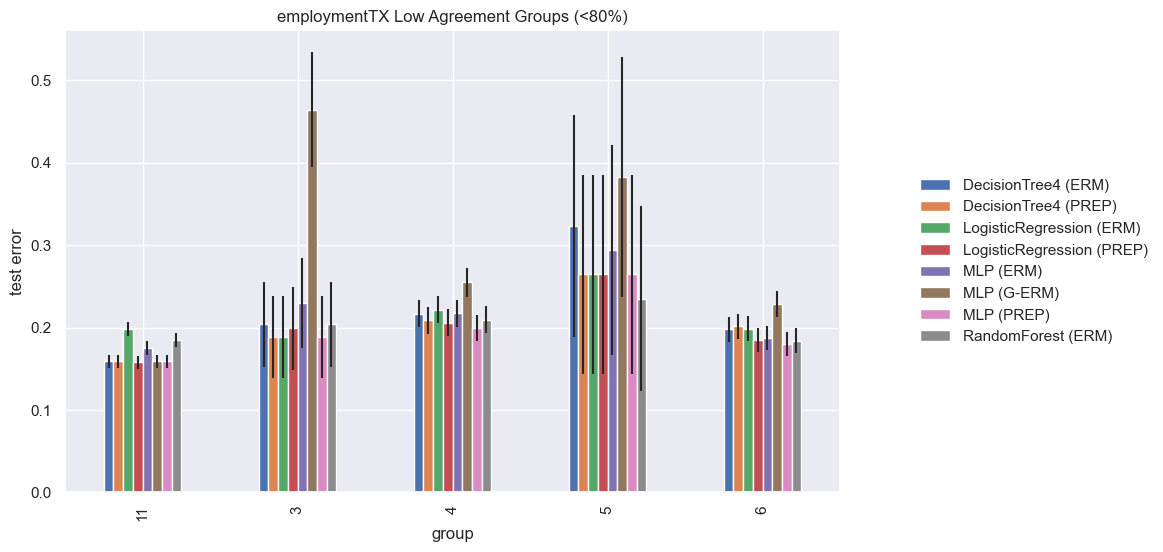

In [112]:
# Low agreement groups
DATASET = 'employmentTX'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "6", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

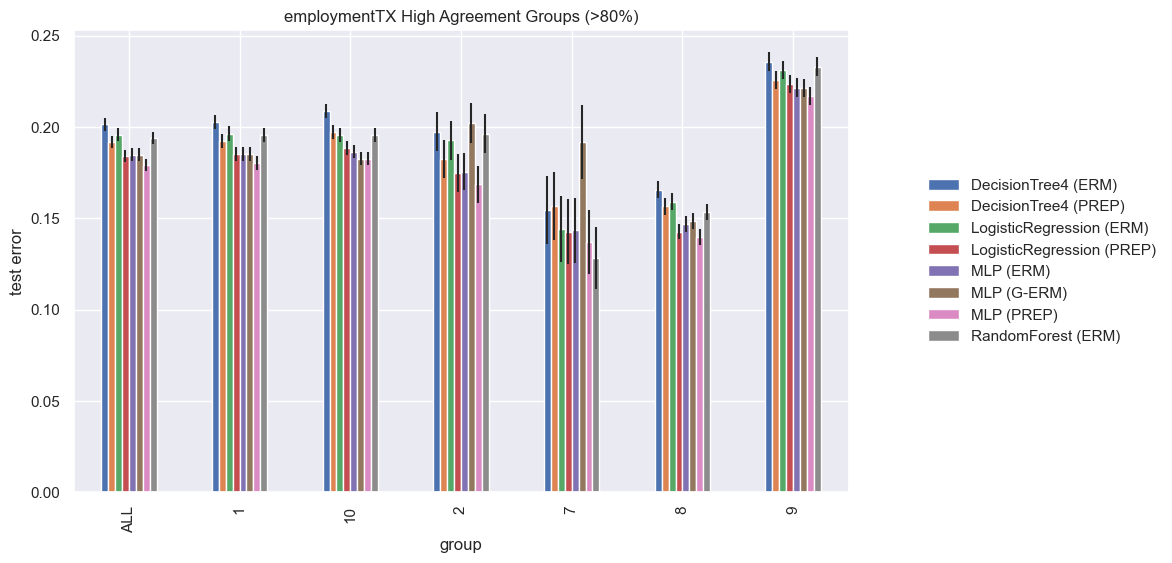

In [113]:
# High agreement groups
DATASET = 'employmentTX'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

### Part 3E: CoverageCA

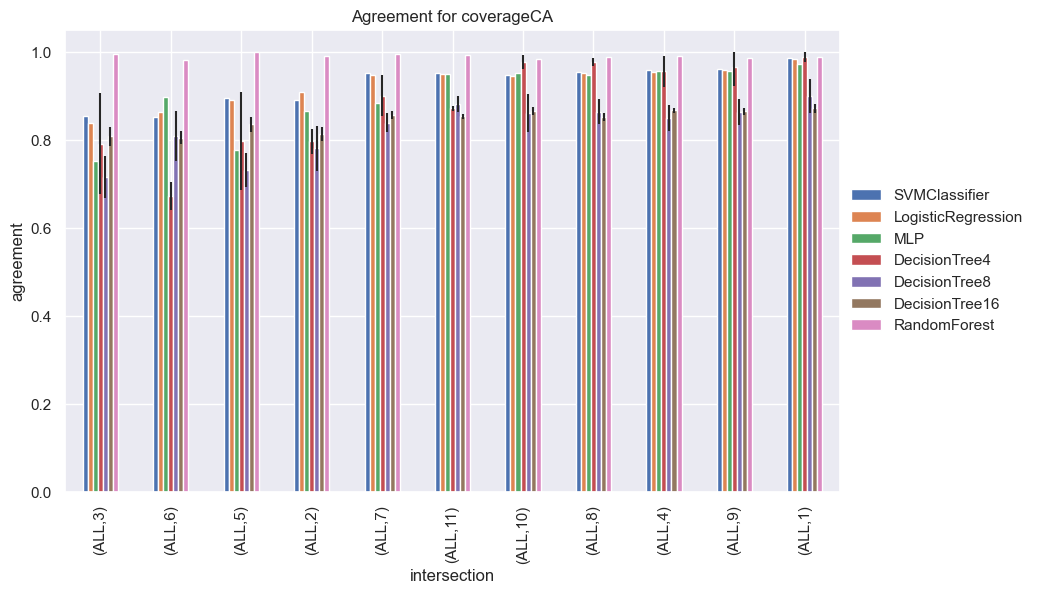

In [114]:
DATASET = 'coverageCA'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

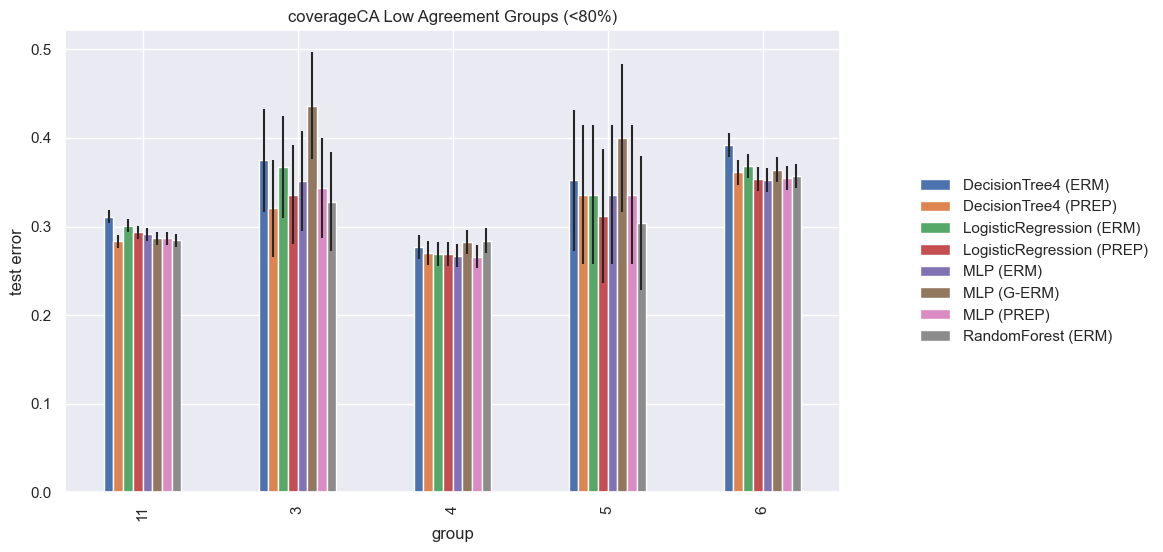

In [115]:
# Low agreement groups
DATASET = 'coverageCA'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "6", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

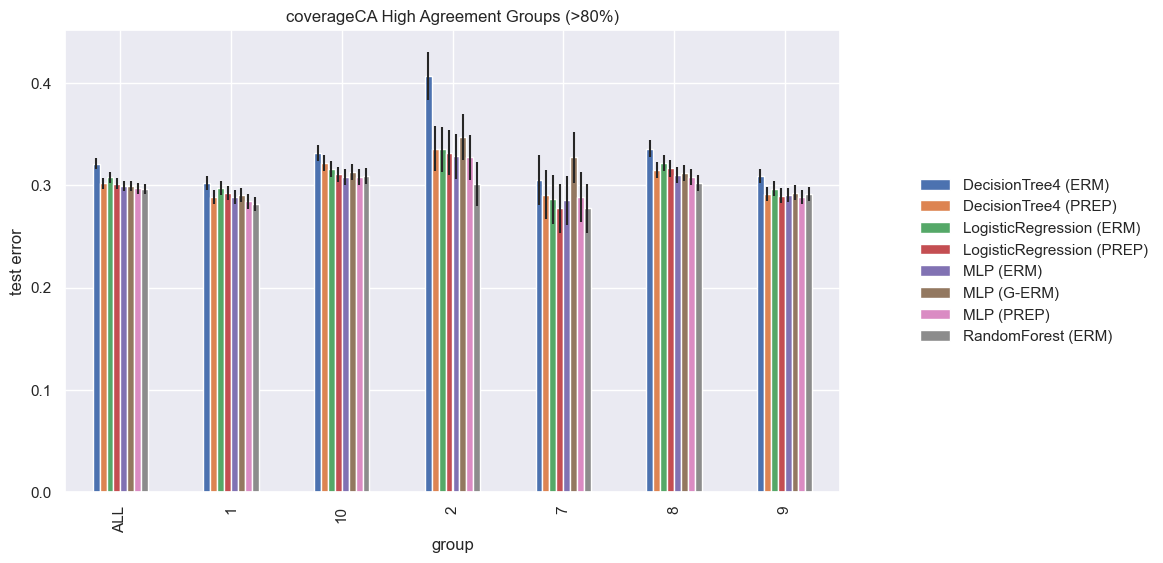

In [116]:
# High agreement groups
DATASET = 'coverageCA'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

### Part 3F: CoverageNY and CoverageTX

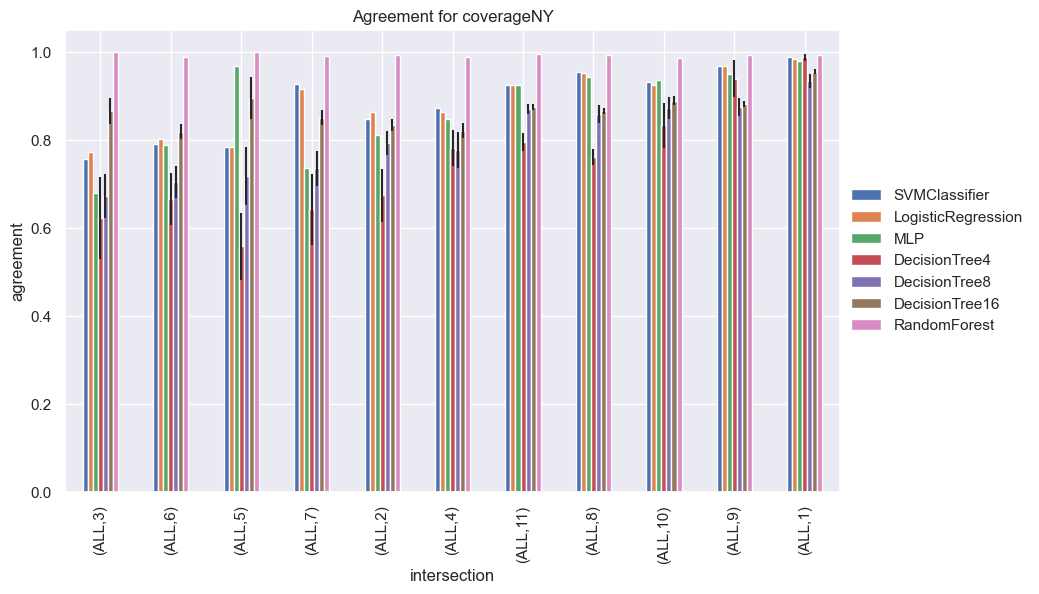

In [117]:
DATASET = 'coverageNY'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

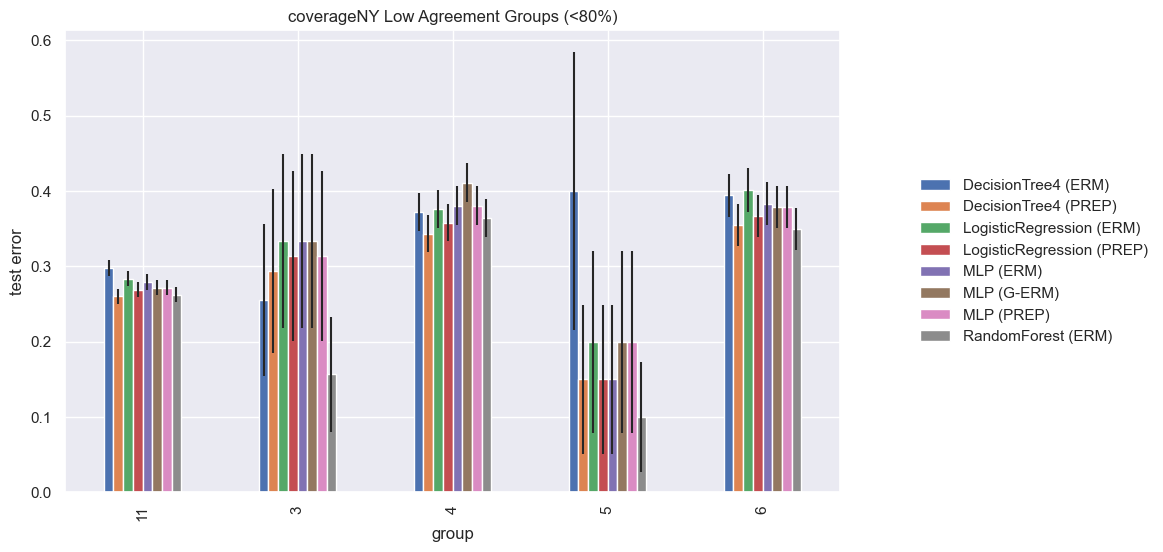

In [118]:
# Low agreement groups
DATASET = 'coverageNY'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "6", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

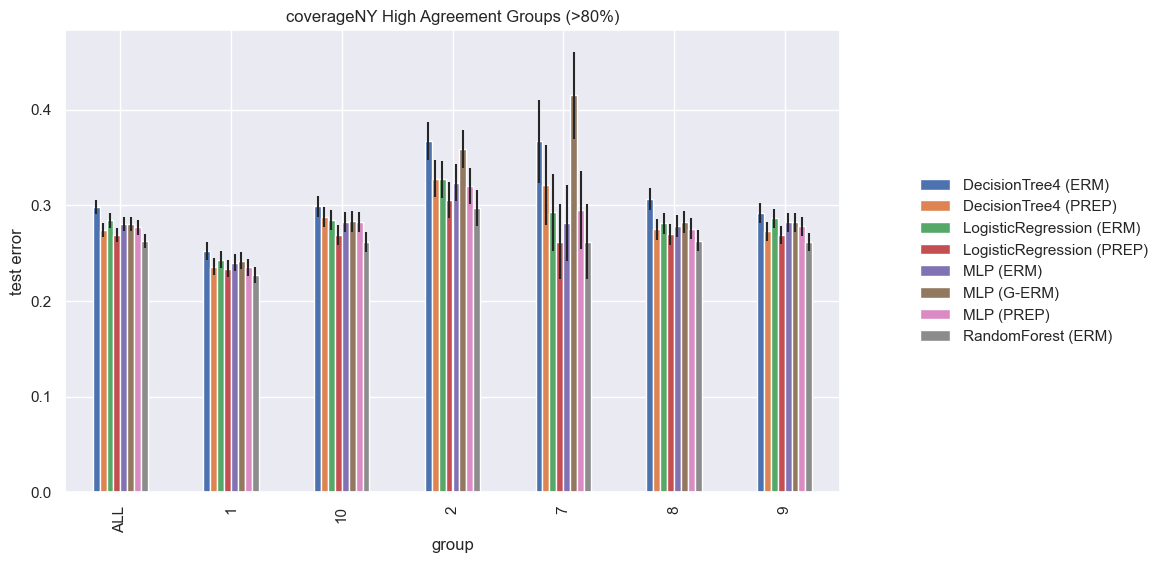

In [119]:
# High agreement groups
DATASET = 'coverageNY'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)

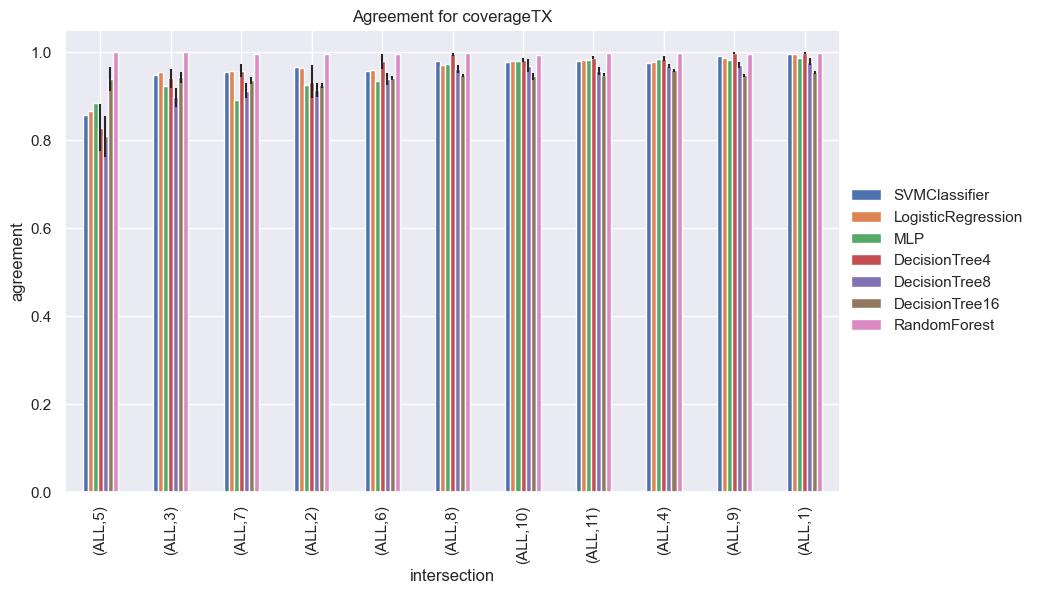

In [120]:
DATASET = 'coverageTX'
models = [
    'SVMClassifier',
    'LogisticRegression',
    'MLP',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'RandomForest'
]

# Sort by average agreement through the intersections
data = dataset_dfs_agree[DATASET].transpose()
agree_list = list(data[models].sum(axis=1)[ALL_INTERSECTIONS])
sorted_intersections = [ALL_INTERSECTIONS[i] for i in np.argsort(agree_list)]

fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_agreement(ax, DATASET, data, models, sorted_intersections)
plt.show()

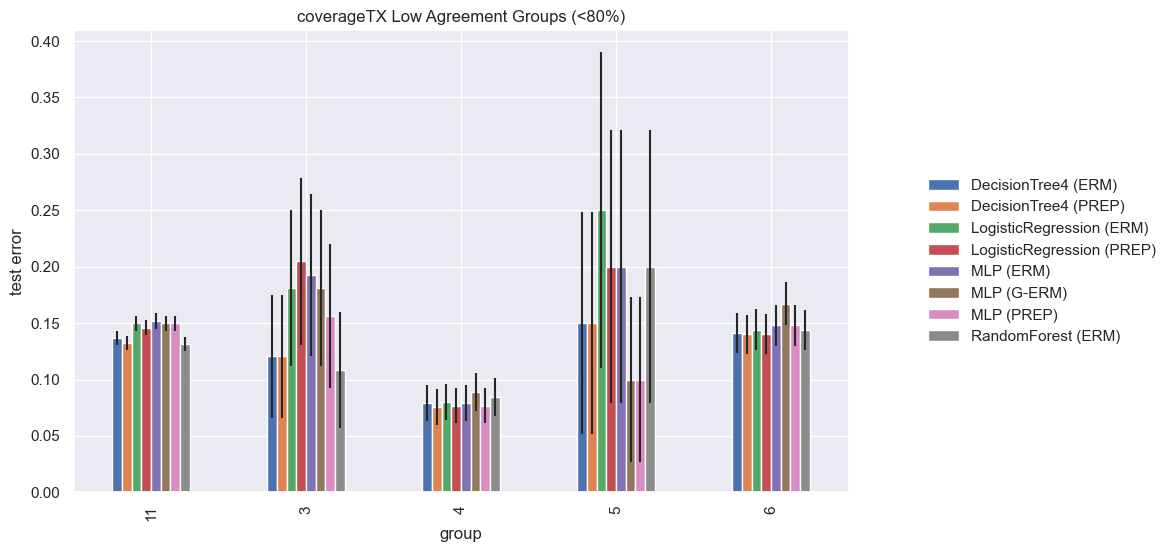

In [121]:
# Low agreement groups
DATASET = 'coverageTX'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
income_low_groups = ["3", "5", "6", "4", "11"]

data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
fig, ax = plt.subplots(figsize=(10, 6))
title = "{} Low Agreement Groups (<80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_low_groups, title=title)

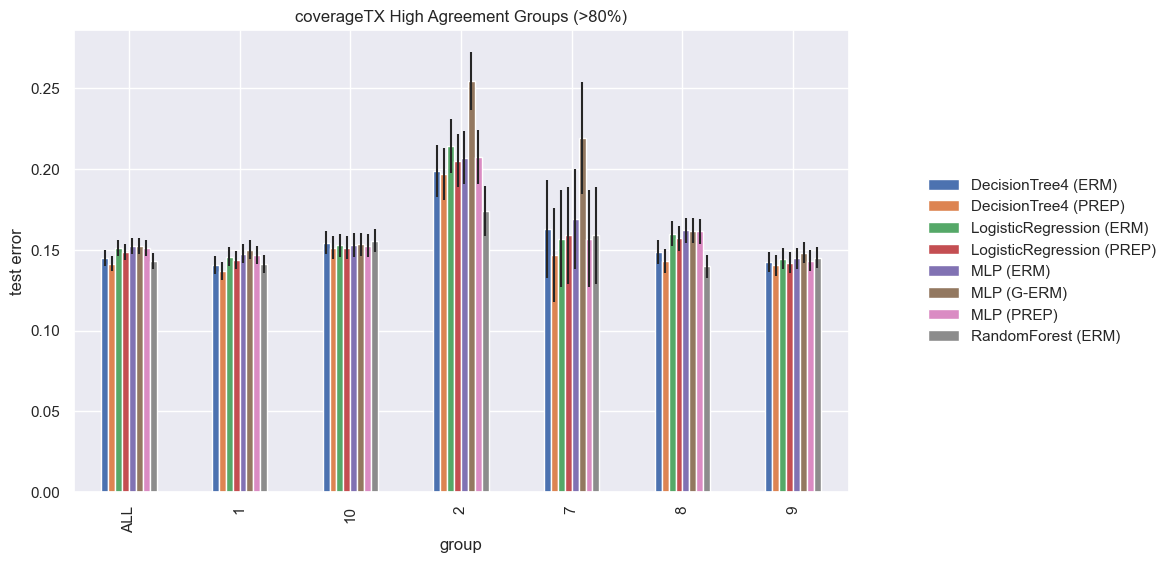

In [122]:
# High agreement groups
DATASET = 'coverageTX'
models = [
    'DecisionTree4 (ERM)',
    'DecisionTree4 (PREP)',
    'MLP (ERM)',
    'MLP (G-ERM)',
    'MLP (PREP)',
    'LogisticRegression (ERM)',
    'LogisticRegression (PREP)',
    'RandomForest (ERM)',
]
data = dataset_dfs_error[DATASET].transpose()
groups = list(data.index)
income_high_groups = list(set(groups) - set(income_low_groups))

fig, ax = plt.subplots(figsize=(10, 6))
title = "{} High Agreement Groups (>80%)".format(DATASET)
ax = plot_error(ax, DATASET, data, models, income_high_groups, title=title)